In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18aczbnhl,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18adairvu,No_TNS,None,-99.0,None
ZTF20aaiwhct,No_TNS,None,-99.0,None
ZTF20aberawv,No_TNS,None,-99.0,None


In [3]:
suffix = f'noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after'
ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF17aaahrni,9210.225154,11484.593750
ZTF17aadqidc,7764.042275,9960.853516
ZTF18aabdnbr,7543.390351,9480.320312
ZTF18aabeszt,7435.207927,9739.706055
ZTF18aabvmws,12485.321591,15887.842773
...,...,...
ZTF21ackmpcb,10116.747454,13165.939453
ZTF21ackwyaz,16908.949160,21727.015625
ZTF21ackzfeh,16899.222193,22110.087891


In [4]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,
ZTF17aaahrni,9210.225154,11484.593750,Yes_TNS,None,-99.000,GaiaAlerts
ZTF17aadqidc,7764.042275,9960.853516,No_TNS,None,-99.000,None
ZTF18aabdnbr,7543.390351,9480.320312,Yes_TNS,None,-99.000,ALeRCE
ZTF18aabeszt,7435.207927,9739.706055,Yes_TNS,SN Ia,0.081,ALeRCE
ZTF18aabvmws,12485.321591,15887.842773,Yes_TNS,None,-99.000,ZTF
...,...,...,...,...,...,...
ZTF21ackmpcb,10116.747454,13165.939453,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackwyaz,16908.949160,21727.015625,Yes_TNS,None,-99.000,ALeRCE
ZTF21ackzfeh,16899.222193,22110.087891,Yes_TNS,None,-99.000,ALeRCE


In [6]:
MO_df = merge_df[(merge_df[dist_col]>=4000) & (merge_df.has_tns == 'No_TNS')]

for sn in MO_df.index:
    print(f'https://alerce.online/object/{sn}')

https://alerce.online/object/ZTF17aadqidc
https://alerce.online/object/ZTF18aaiuynw
https://alerce.online/object/ZTF18aajgowk
https://alerce.online/object/ZTF18aajkgtr
https://alerce.online/object/ZTF18aajmlnp
https://alerce.online/object/ZTF18aakeanj
https://alerce.online/object/ZTF18aamfwcd
https://alerce.online/object/ZTF18aaqdlle
https://alerce.online/object/ZTF18aaqzdge
https://alerce.online/object/ZTF18aathofv
https://alerce.online/object/ZTF18aautymc
https://alerce.online/object/ZTF18aawlezq
https://alerce.online/object/ZTF18aawonvg
https://alerce.online/object/ZTF18aaxckpt
https://alerce.online/object/ZTF18aaxmacd
https://alerce.online/object/ZTF18aaxmjit
https://alerce.online/object/ZTF18aaxqwnd
https://alerce.online/object/ZTF18aaxzhzf
https://alerce.online/object/ZTF18aayyedm
https://alerce.online/object/ZTF18aazijer
https://alerce.online/object/ZTF18aazydub
https://alerce.online/object/ZTF18abgucur
https://alerce.online/object/ZTF18abiitmq
https://alerce.online/object/ZTF18

<ipython-input-7-61edf991ff0b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


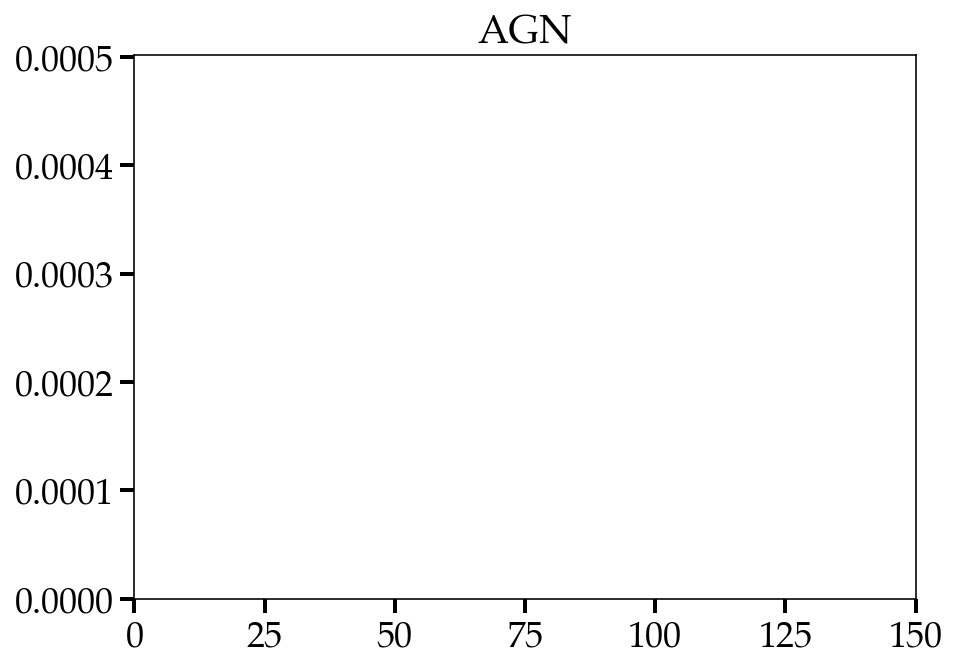

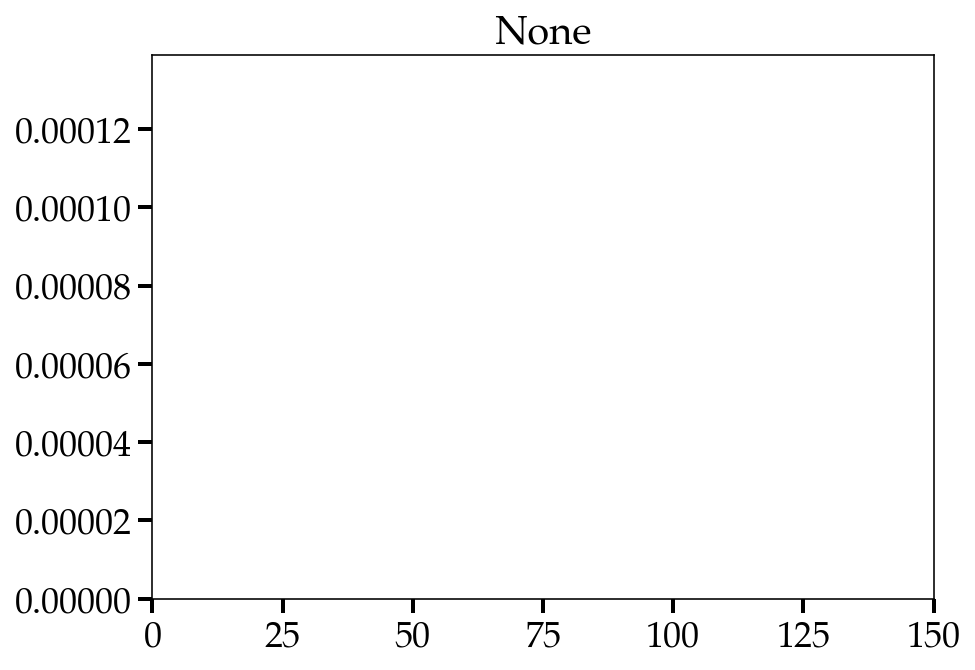

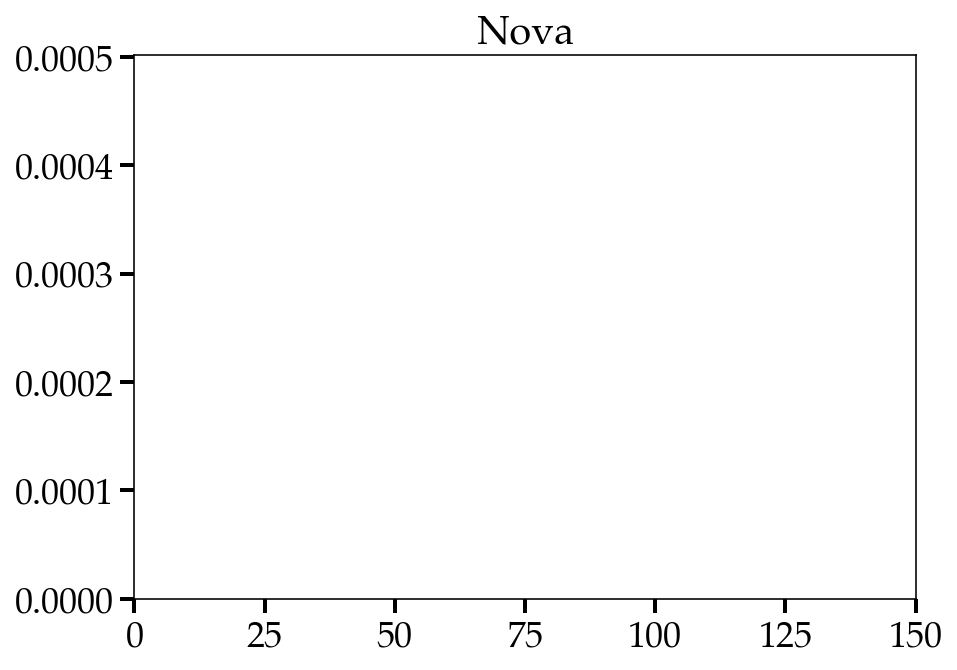

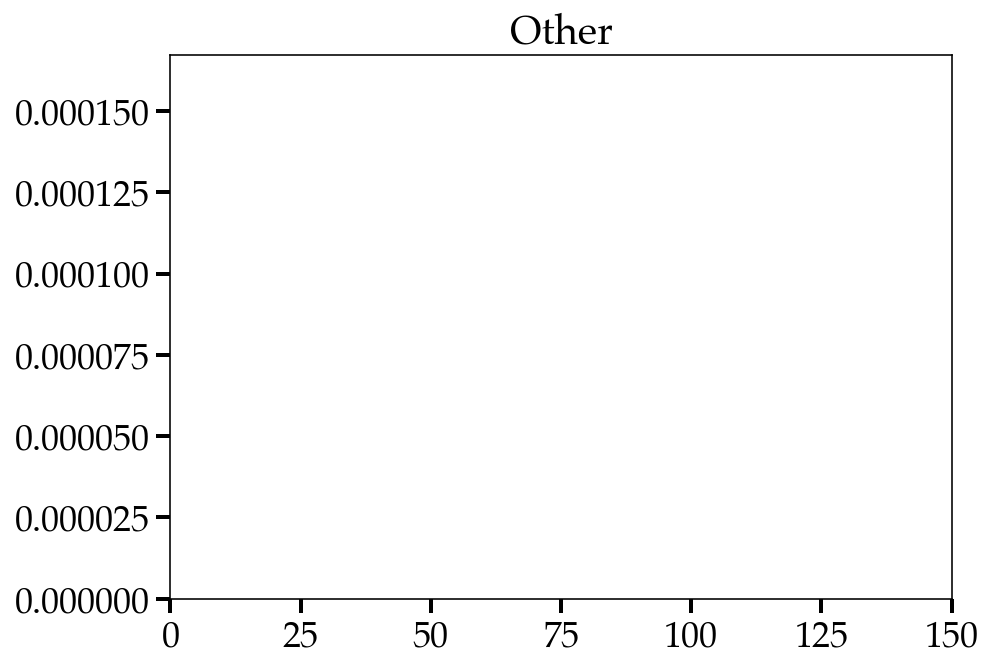

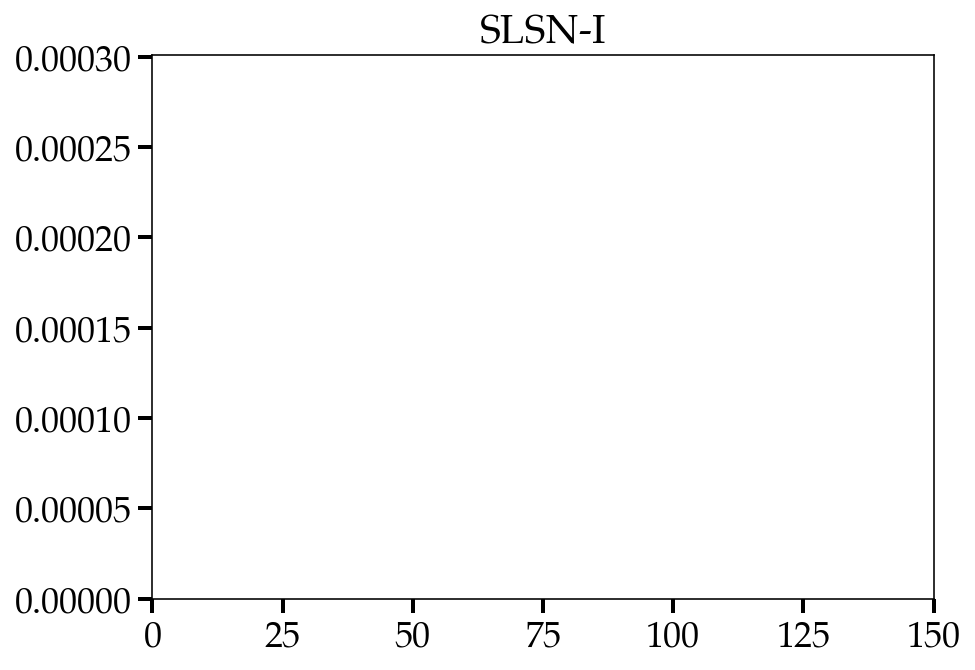

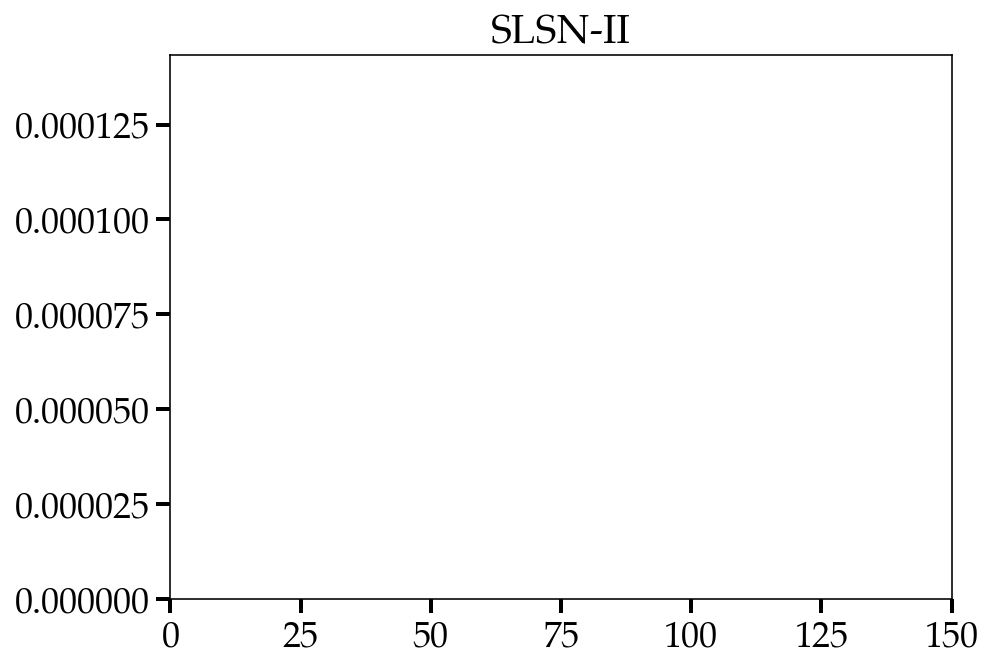

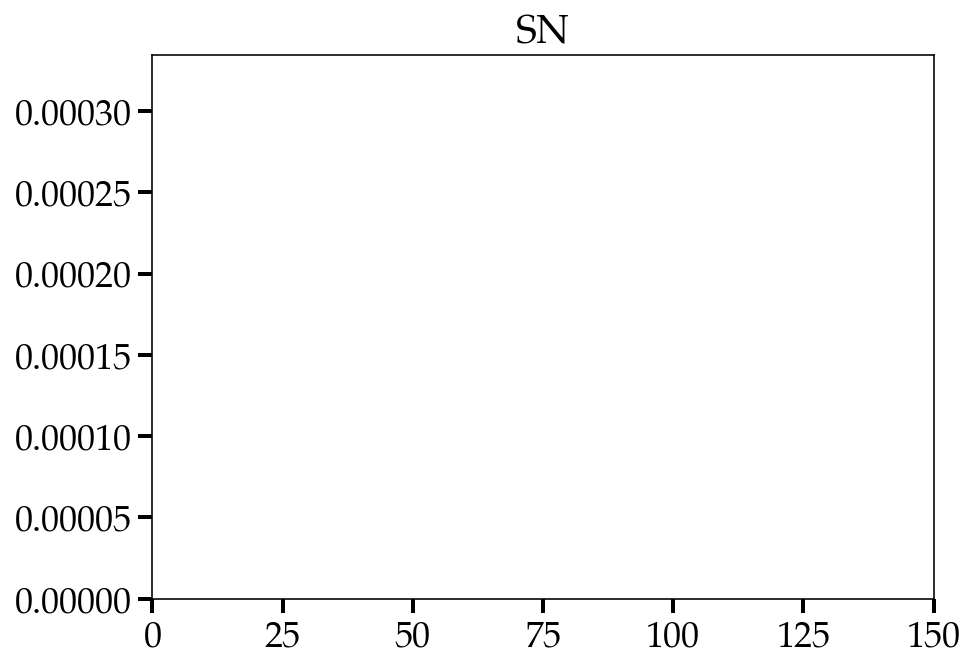

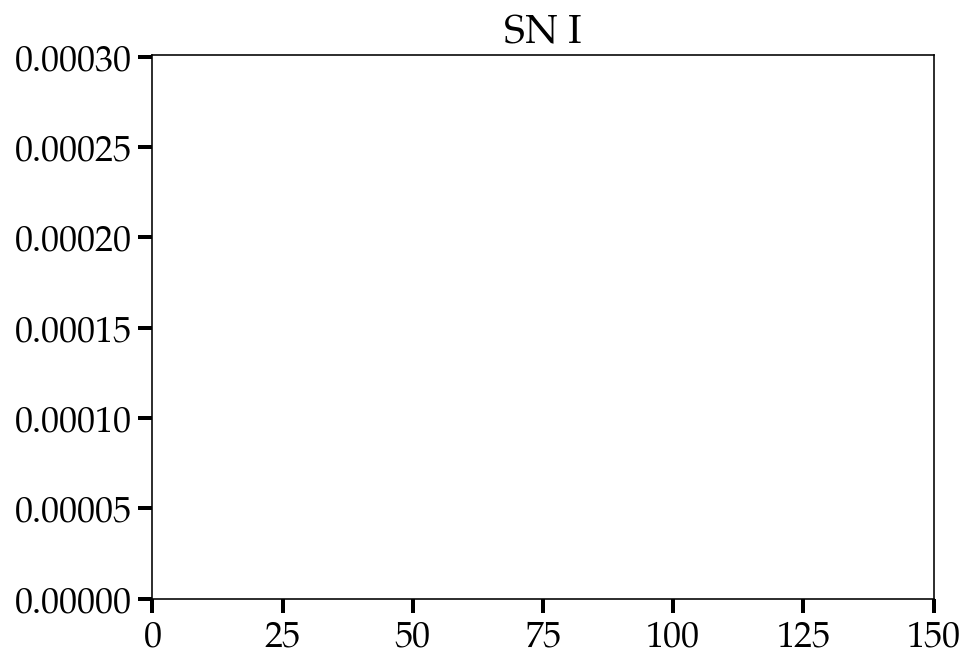

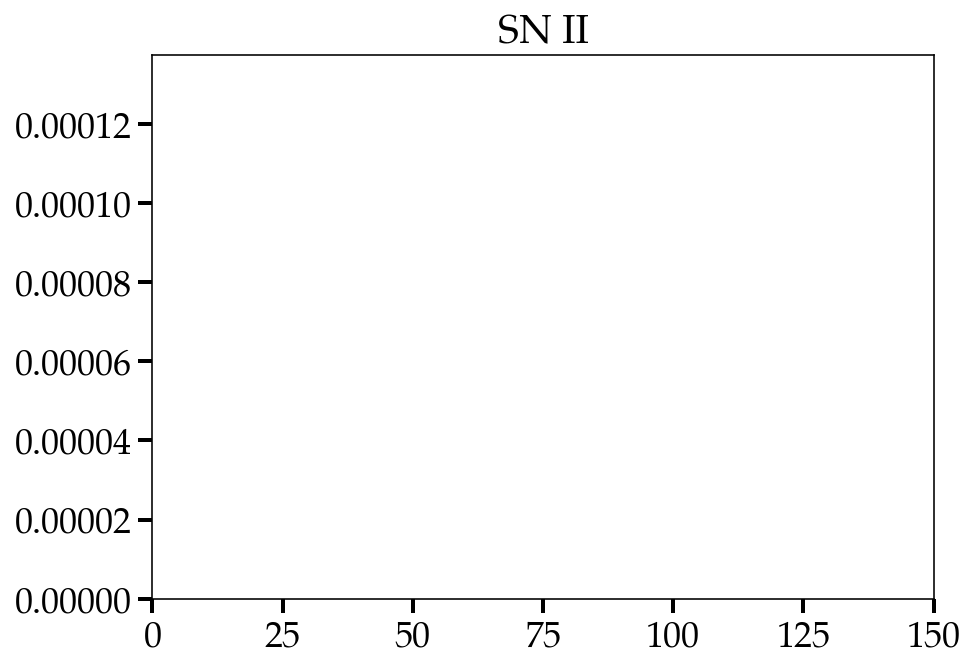

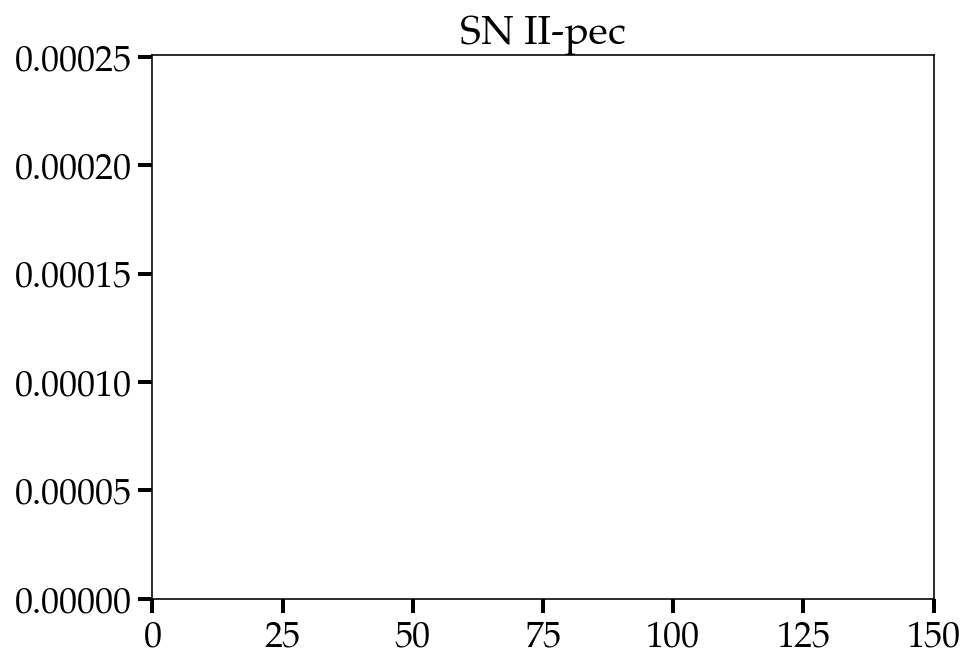

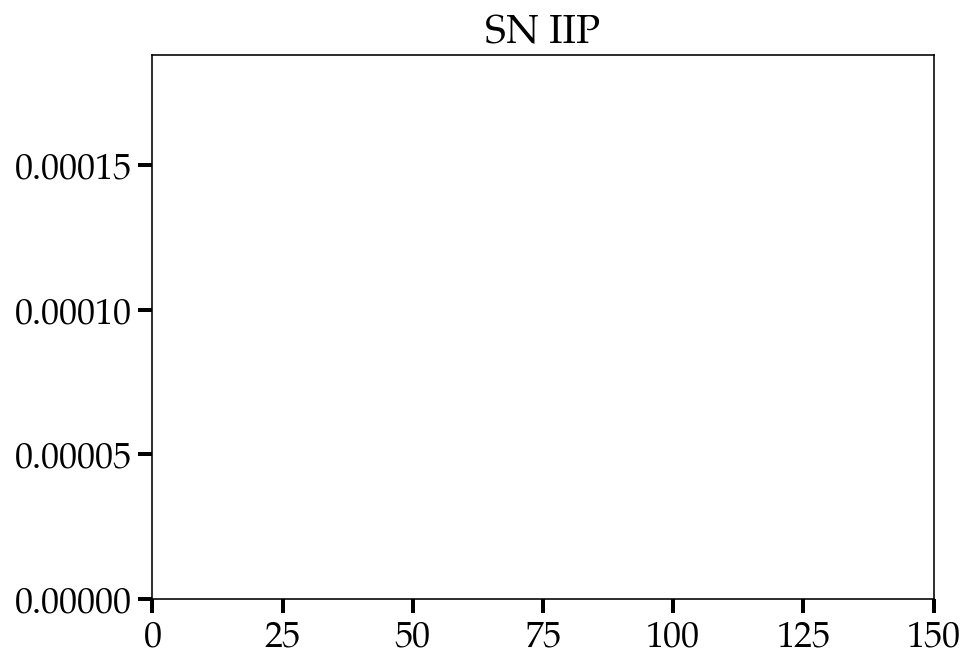

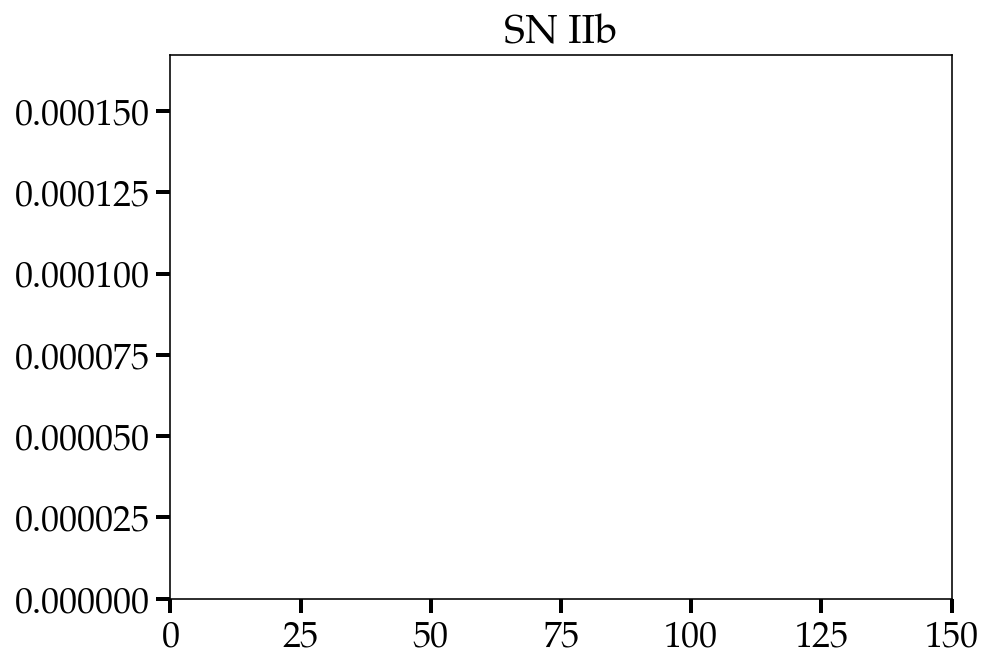

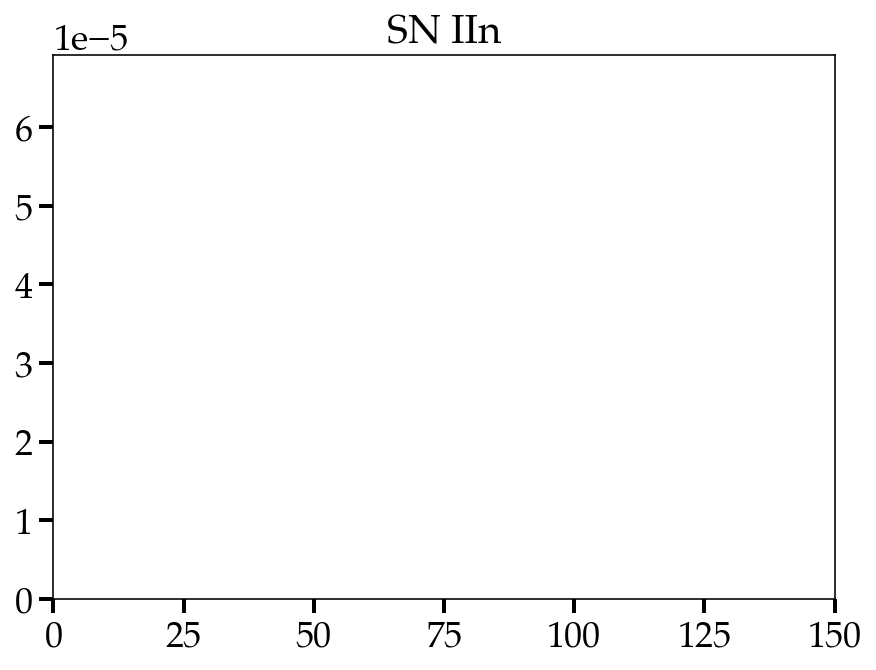

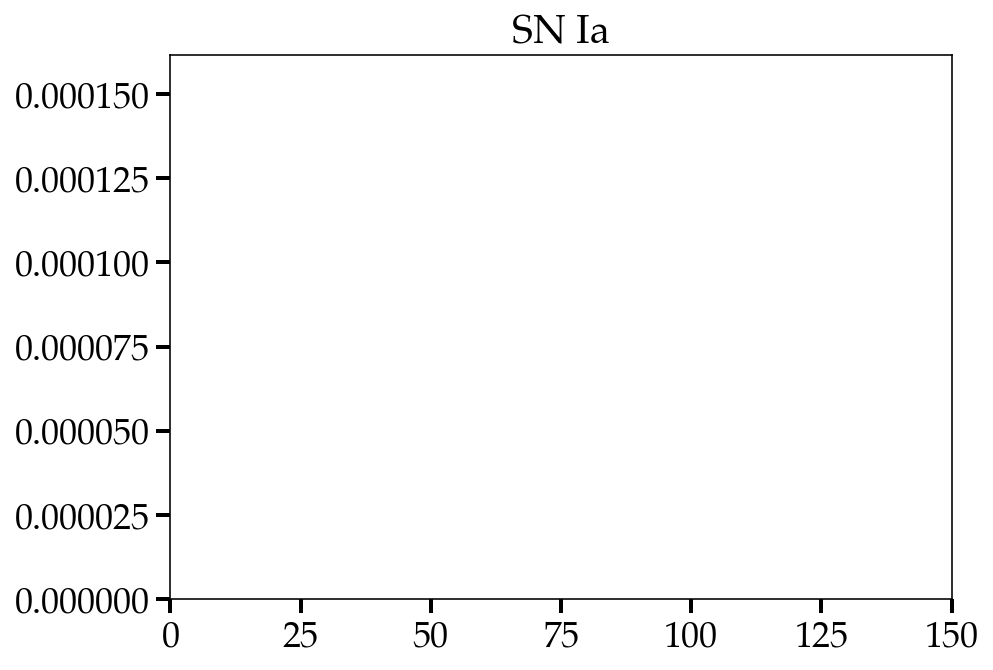

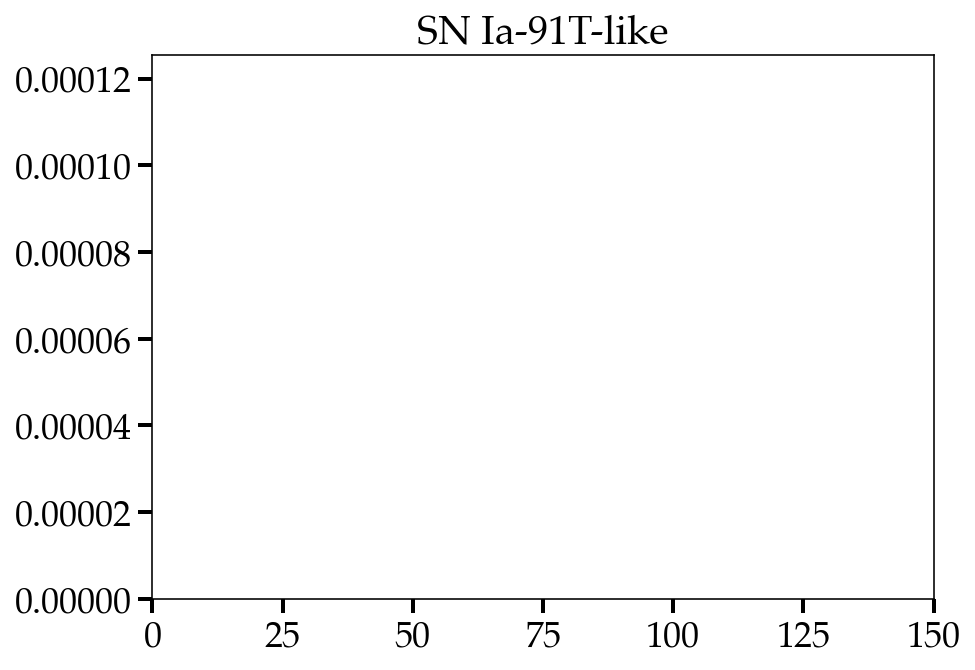

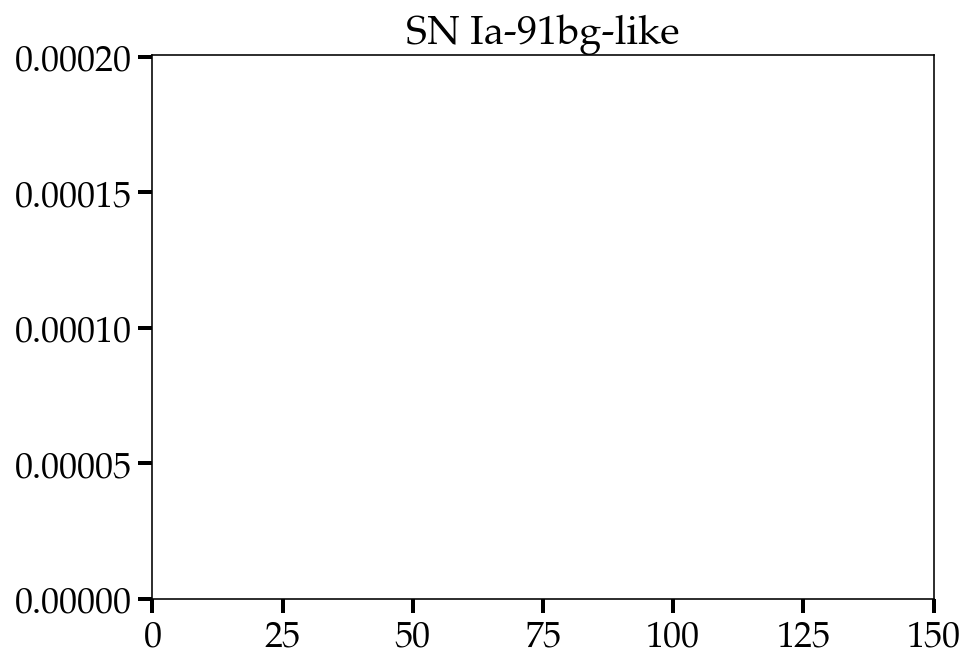

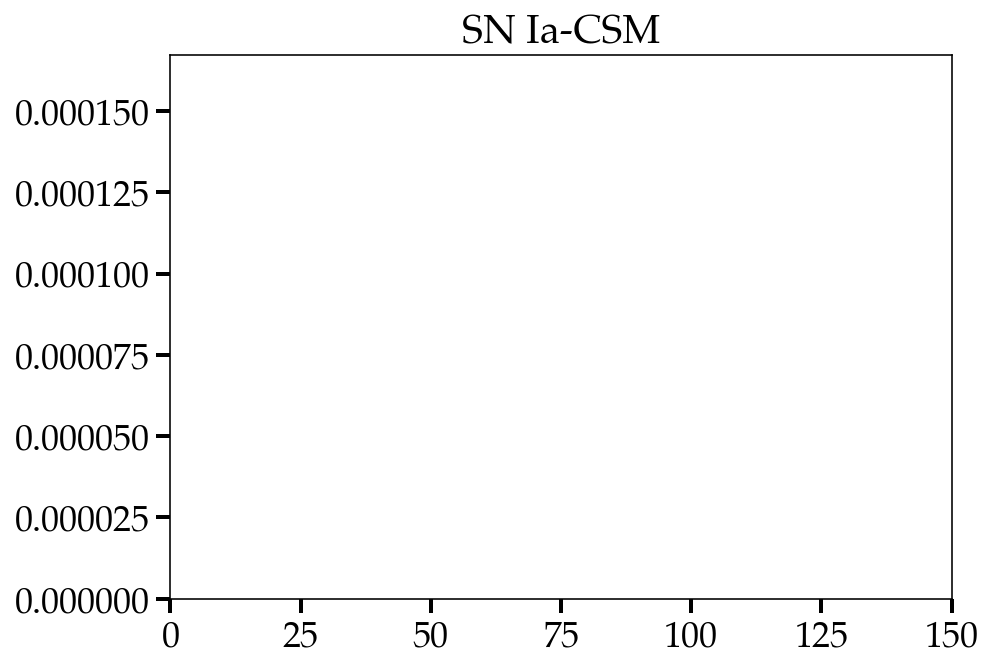

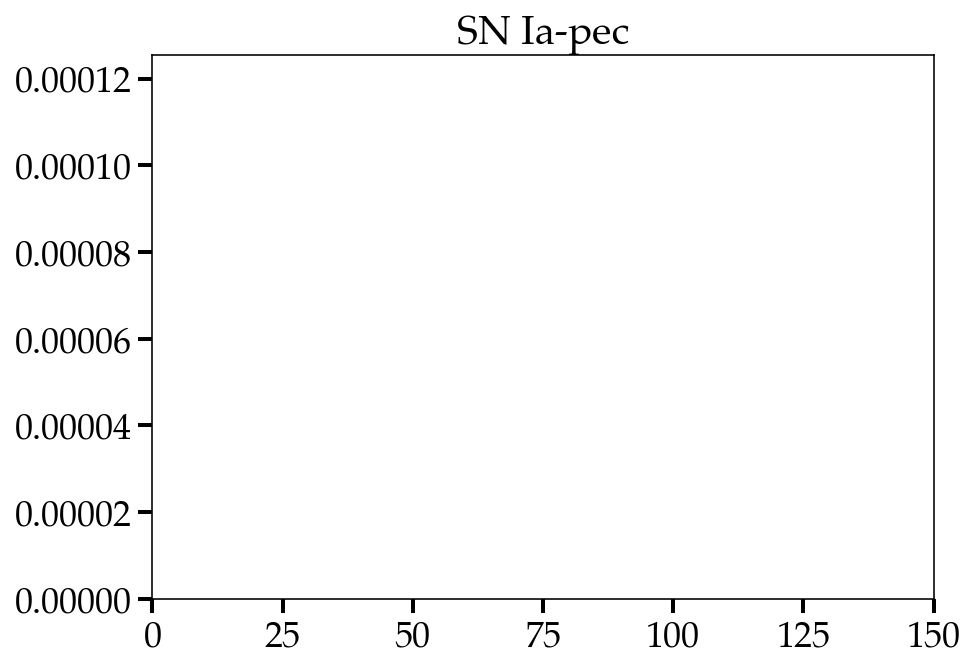

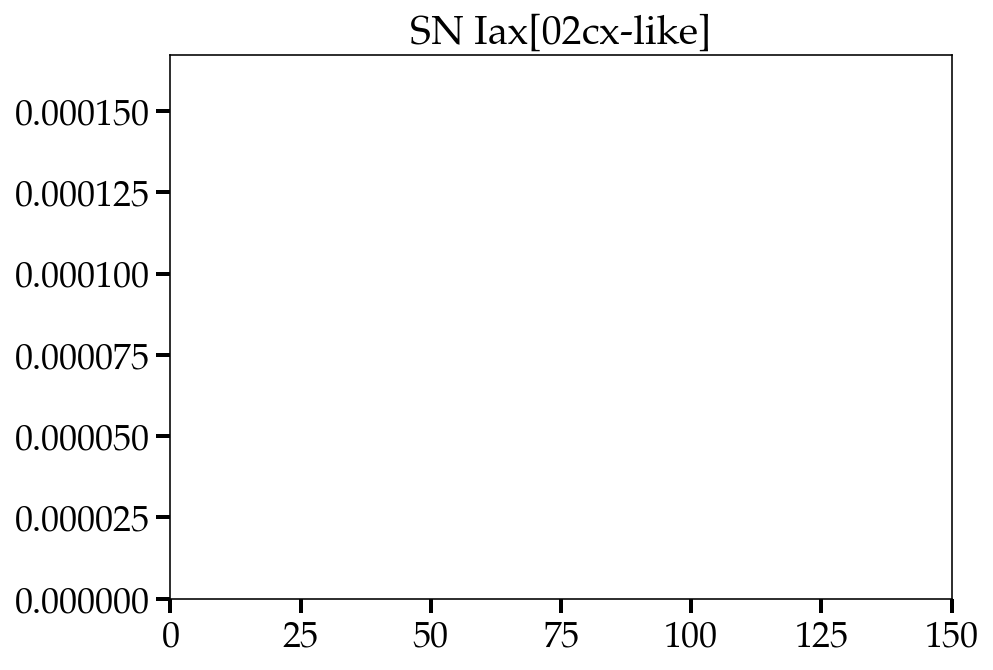

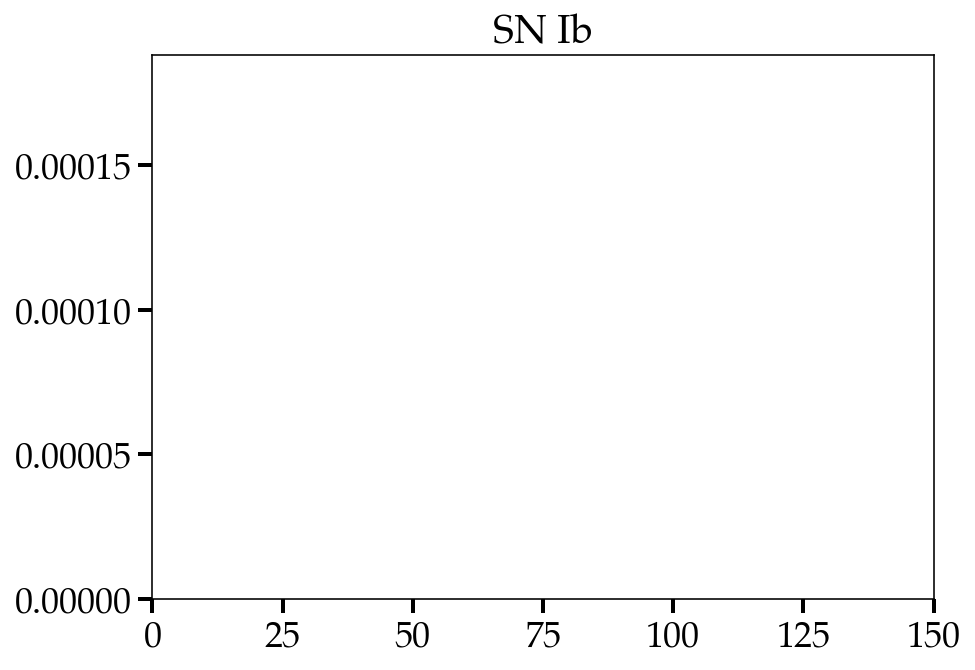

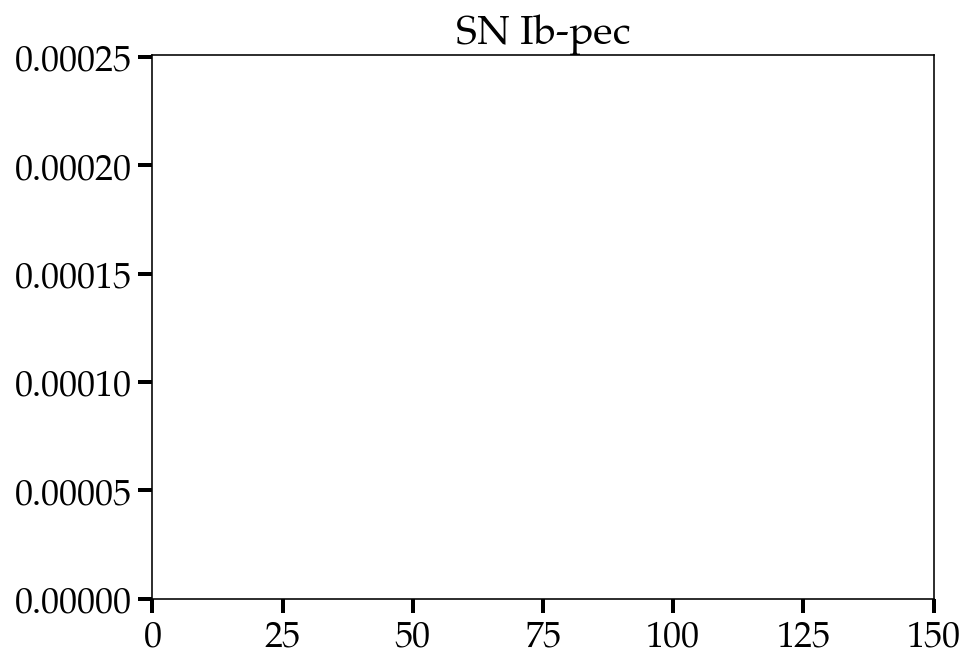

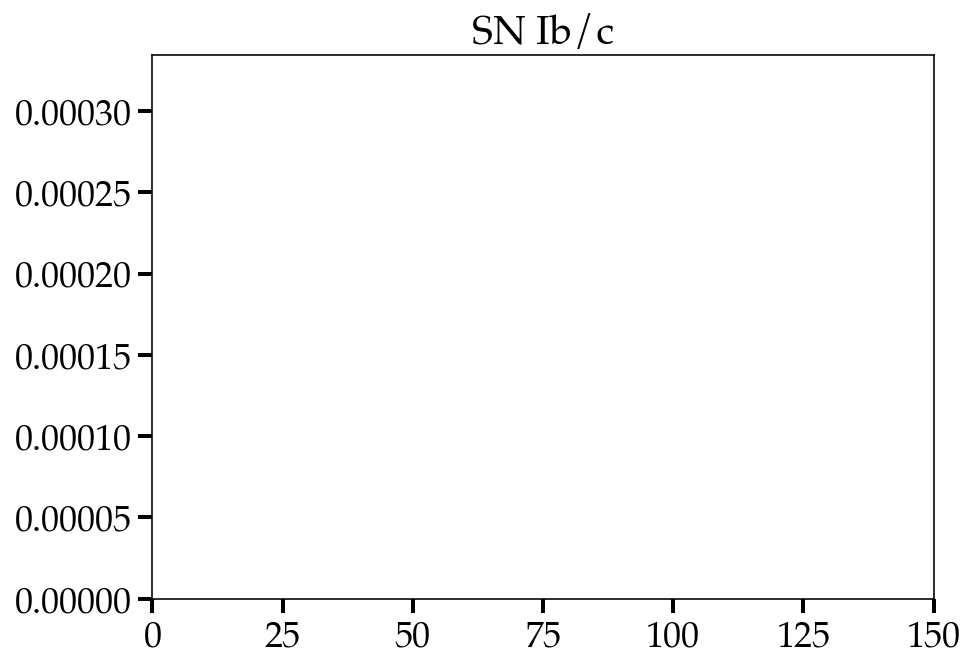

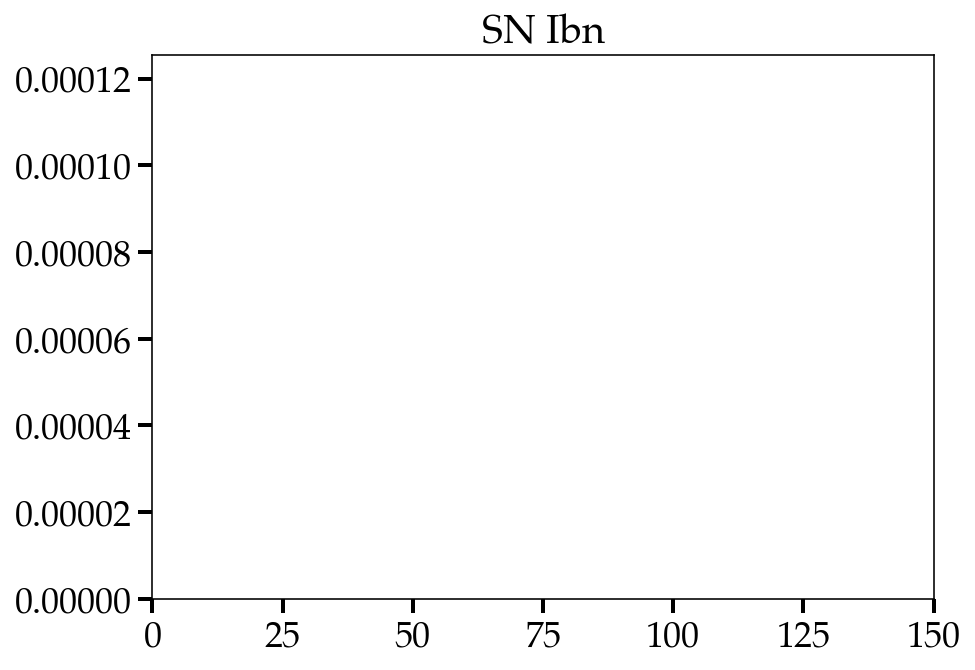

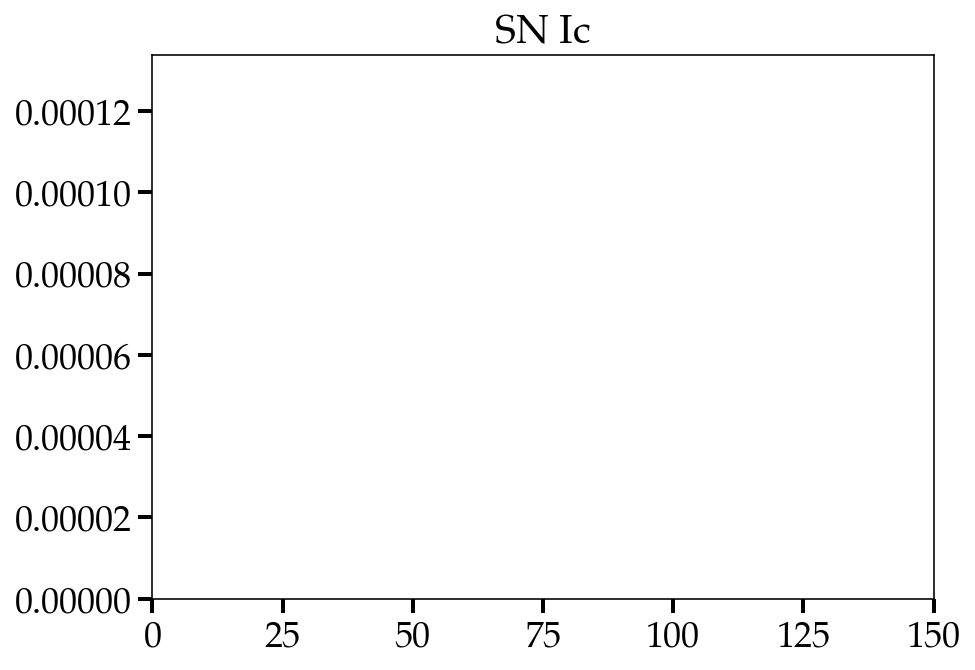

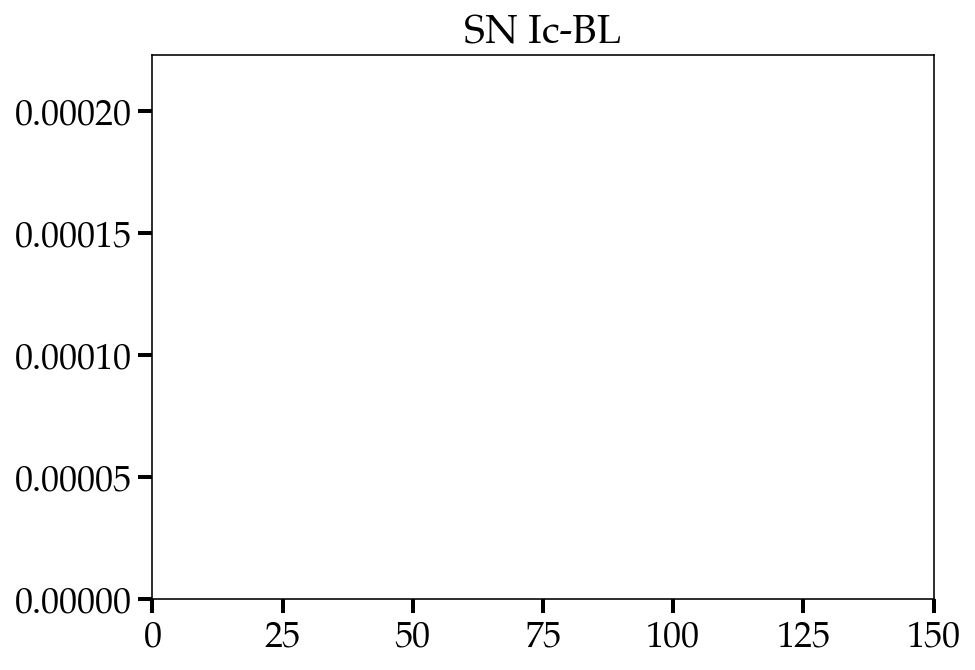

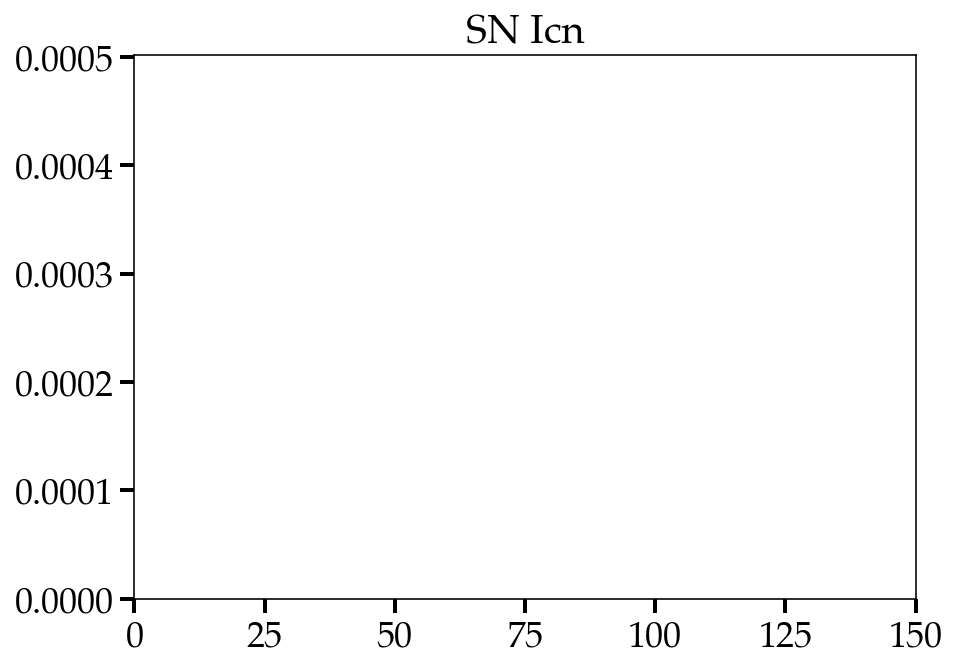

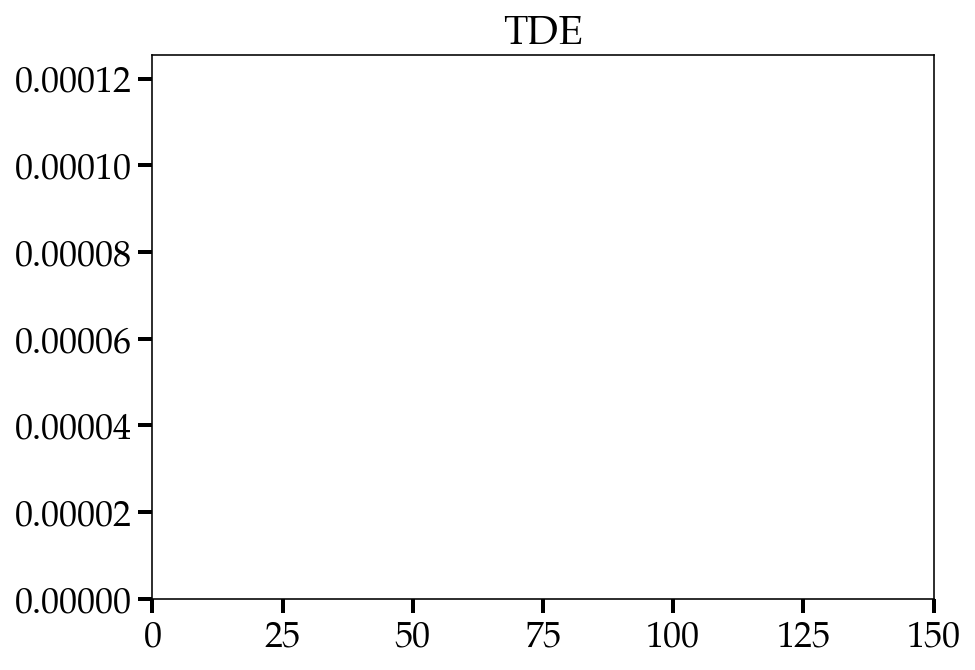

In [7]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges


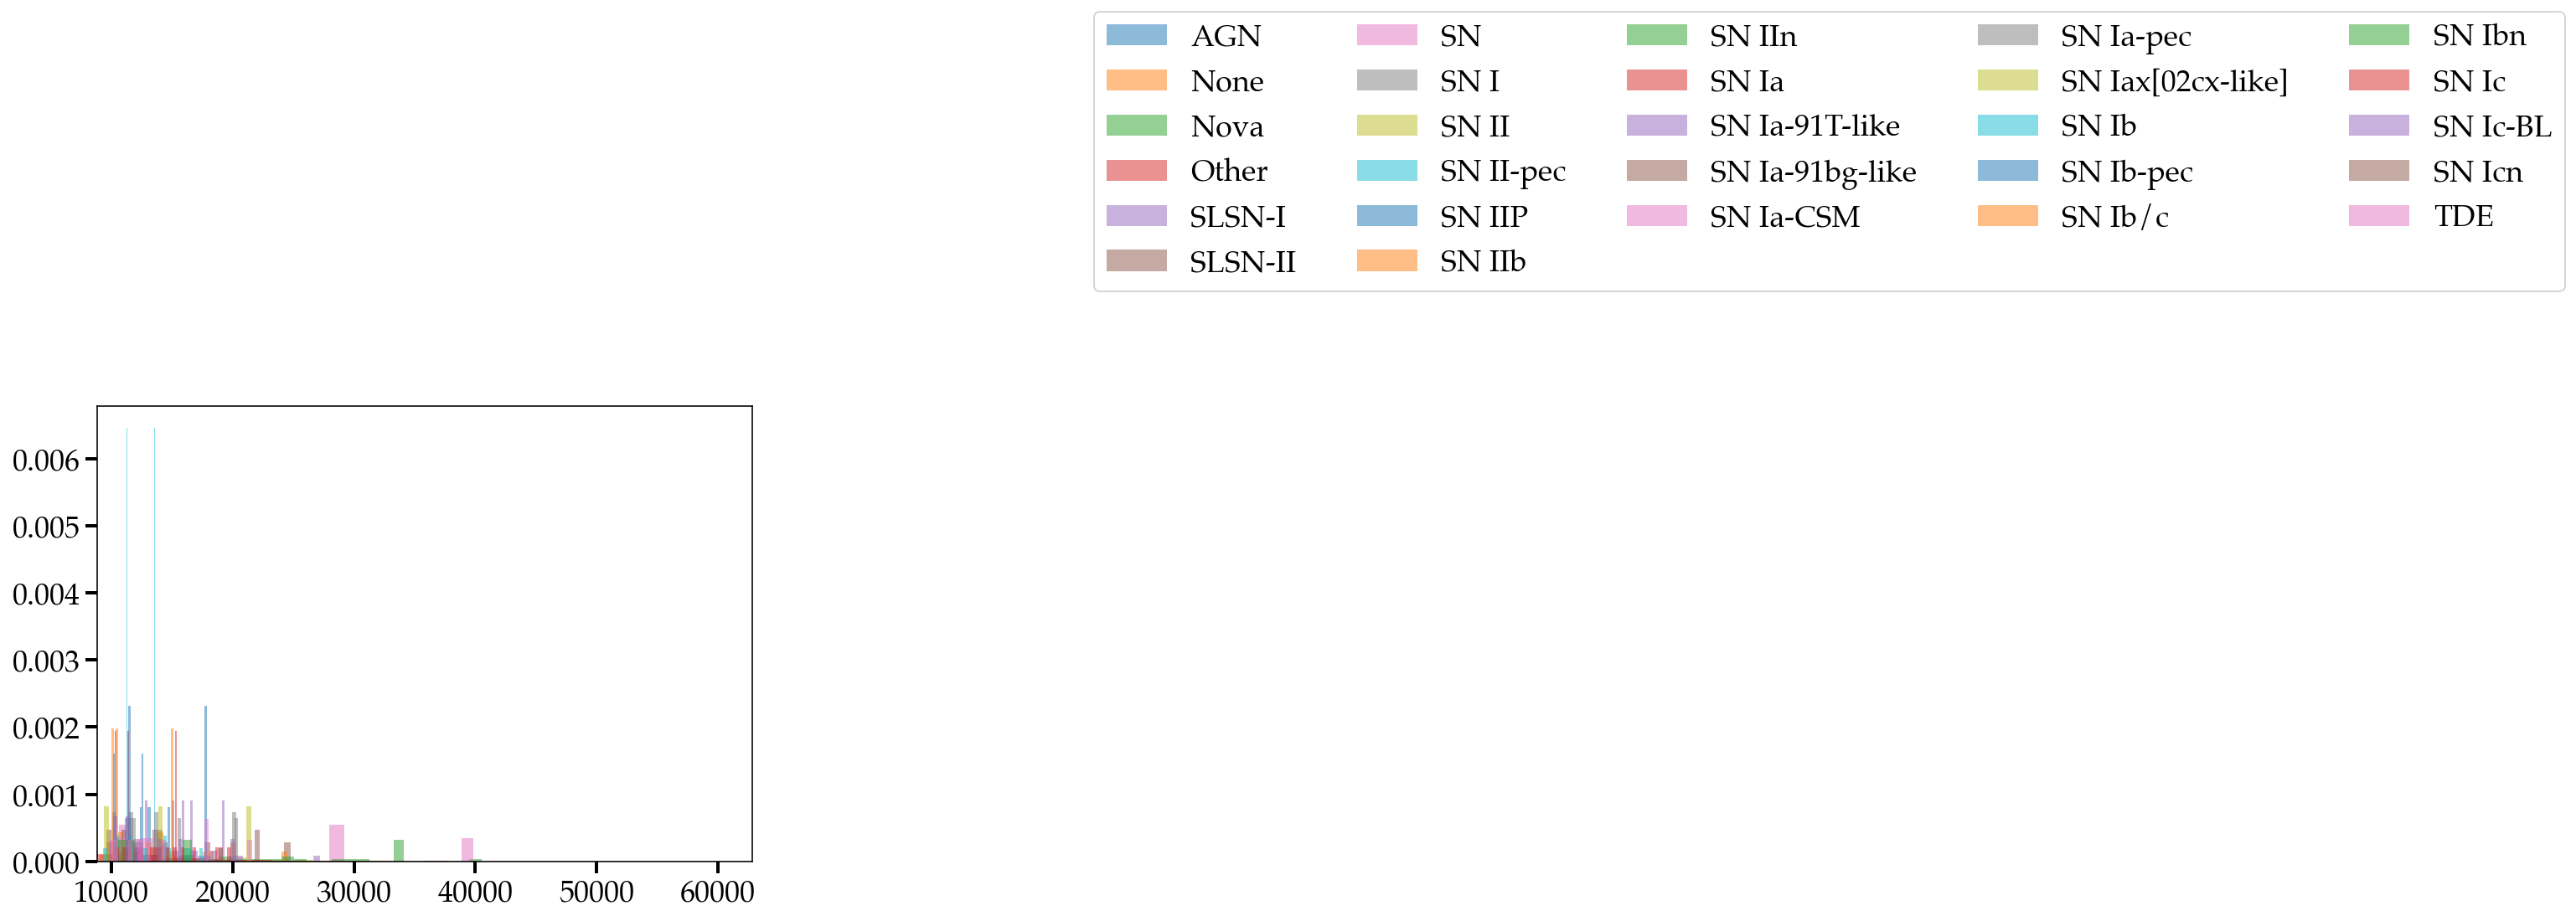

In [27]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

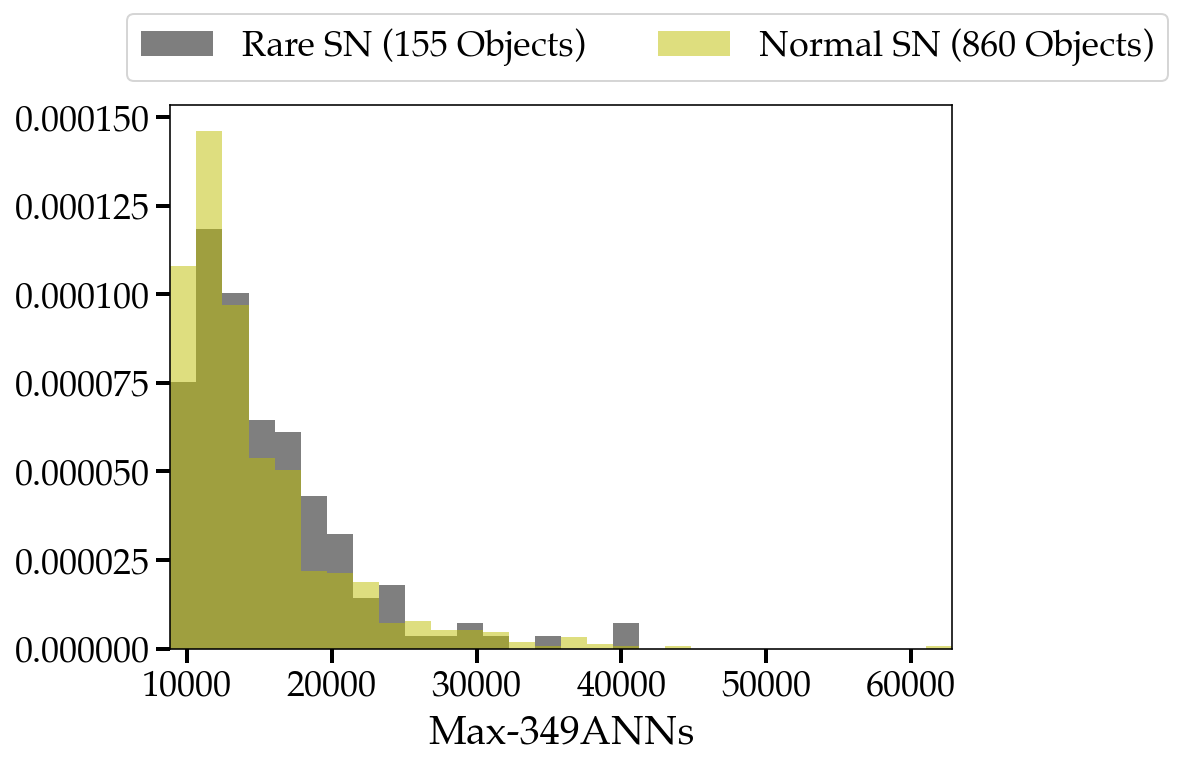

In [9]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [10]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.1935483870967742
P-value: 0.10009620892644118
The two distributions are likely the same.


In [11]:
np.median(normal_sn_df[dist_col])

12744.10205078125

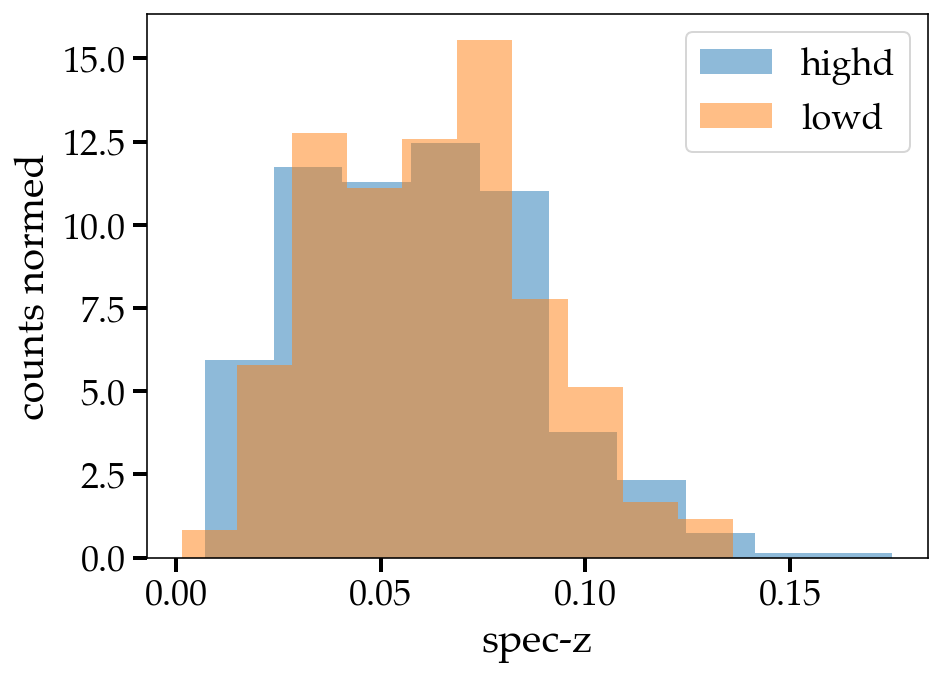

In [12]:
normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= 13000]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= 13000]

plt.hist(normal_sn_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [13]:
len(normal_sn_highd_df)

411

In [14]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.0681265206812652
P-value: 0.2095145160450294
The two distributions are likely the same.


In [15]:
np.median(rare_sn_df[dist_col])

14018.34765625

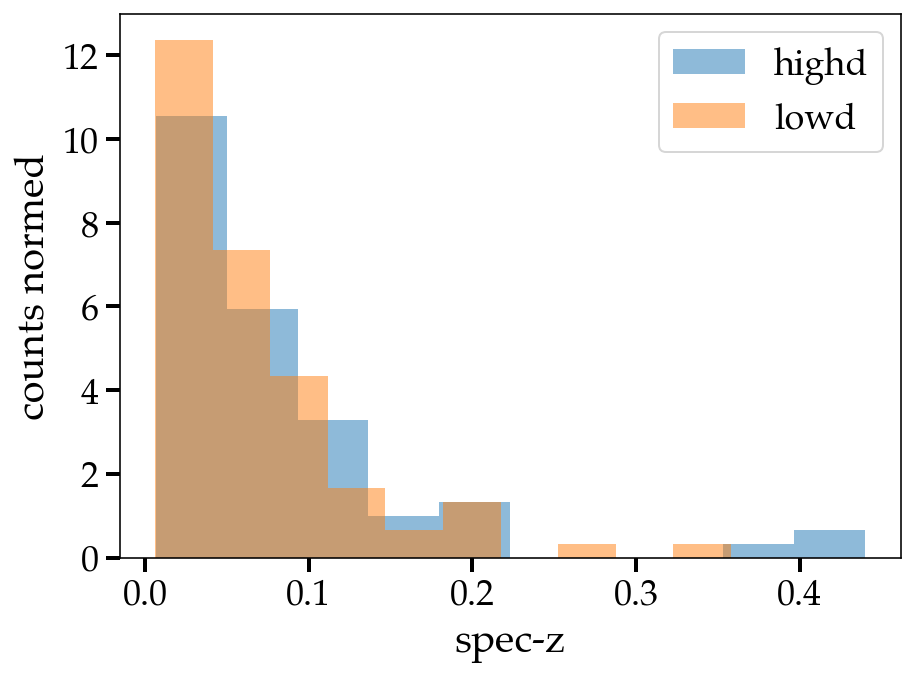

In [19]:
rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= 14500]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= 14500]

plt.hist(rare_sn_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [20]:
len(rare_sn_lowd_df)

85

In [22]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.17142857142857143
P-value: 0.5168130944639951
The two distributions are likely the same.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

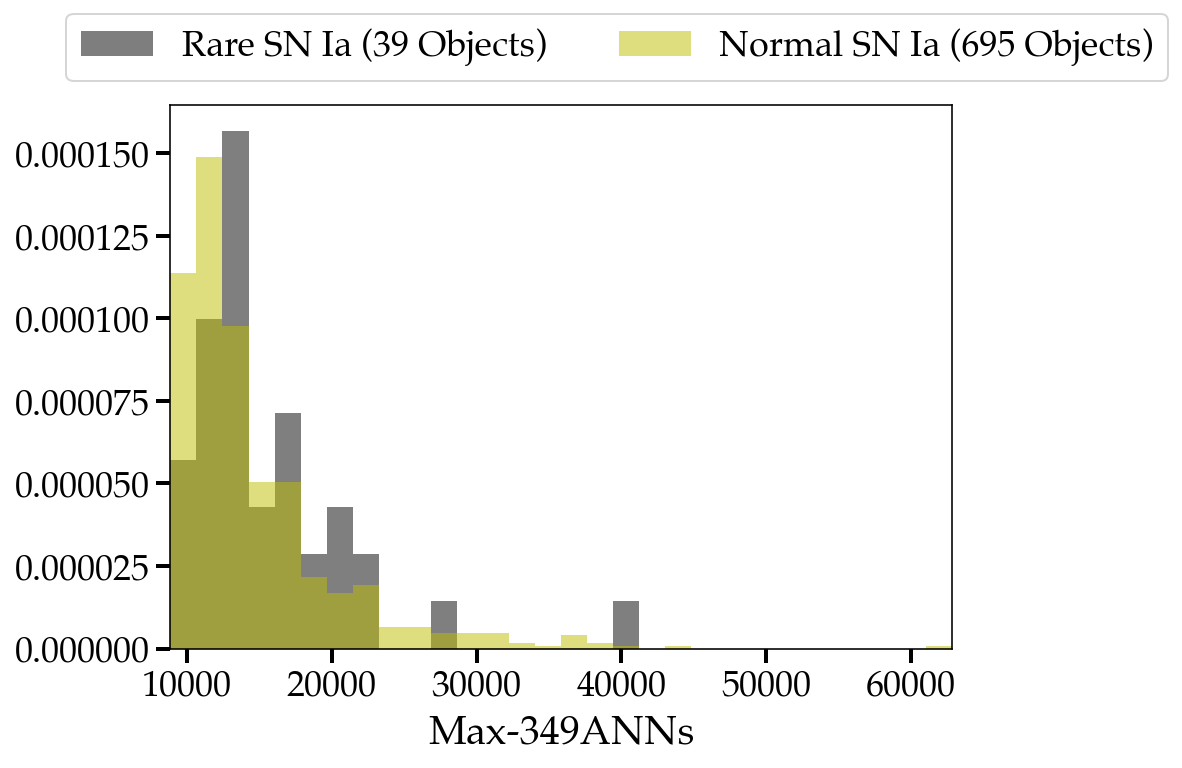

In [28]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [29]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.28205128205128205
P-value: 0.27301796665339434
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [30]:
np.median(normal_snIa_df[dist_col])

12639.548828125

In [33]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= 13000]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= 13000]

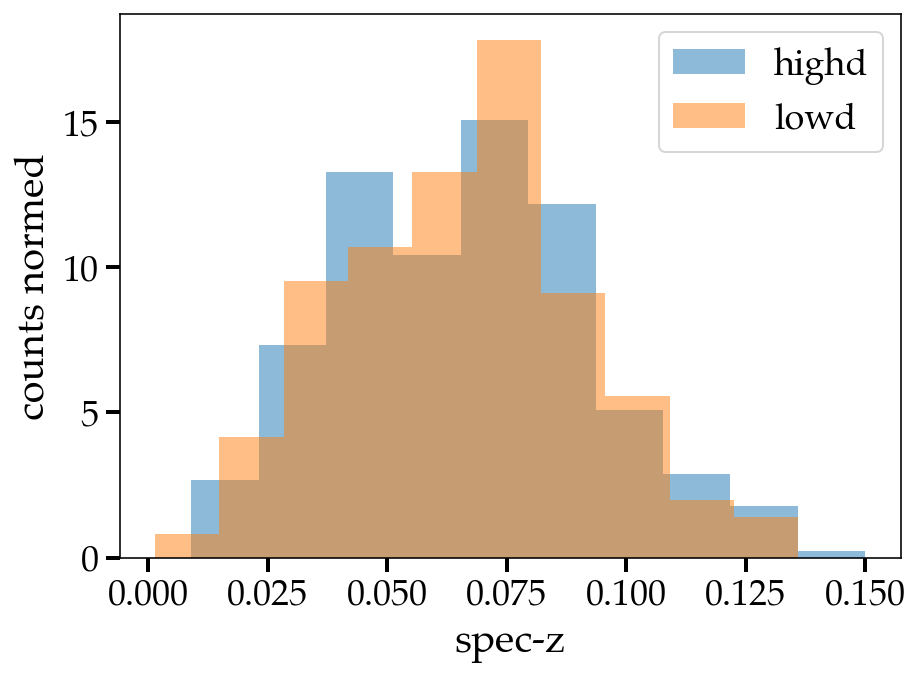

In [34]:
plt.hist(normal_snIa_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [35]:
normal_snIa_highd_df.spec_z

ztf_object_id
ZTF18aaizgoq    0.070000
ZTF18aatgdph    0.035896
ZTF18aatrkga    0.028500
ZTF18aayyqia    0.069100
ZTF18abrbywo    0.043500
                  ...   
ZTF21acenkuf    0.012319
ZTF21acgyzel    0.049000
ZTF21achauvx    0.041000
ZTF21ackbbfs    0.045000
ZTF21acldmwy    0.110000
Name: spec_z, Length: 320, dtype: float64

In [36]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.05625
P-value: 0.7943904542744211
The two distributions are likely the same.


In [39]:
np.median(rare_snIa_df[dist_col])

14007.4609375

In [40]:

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= 14500]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= 14500]

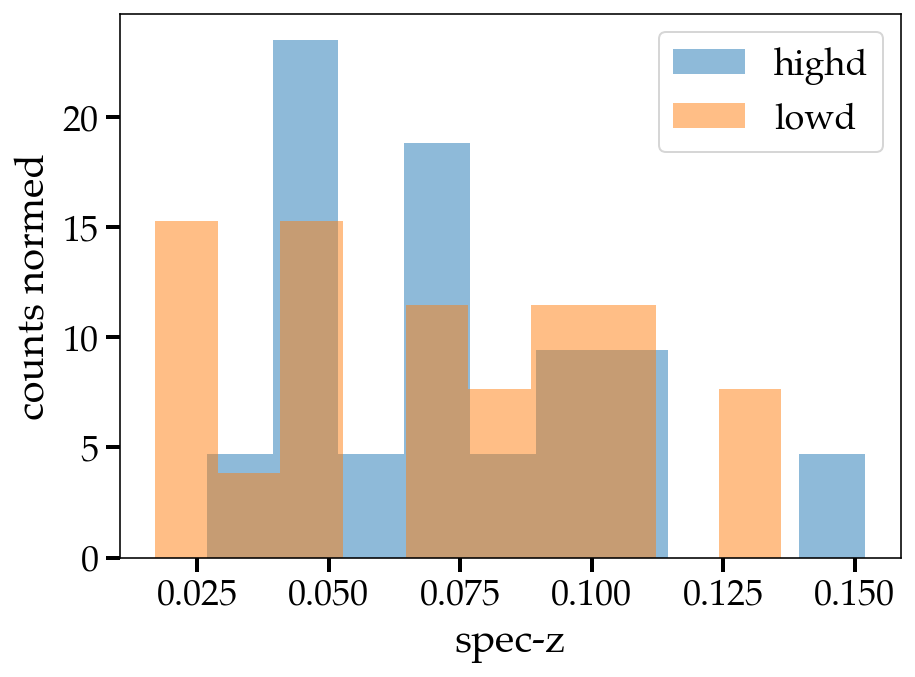

In [41]:
plt.hist(rare_snIa_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [42]:
len(rare_snIa_highd_df)

17

In [43]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.23529411764705882
P-value: 0.8714732717999013
The two distributions are likely the same.


# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: now brightness has been normalized out! So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

In [44]:
# rare b/c closeby and bright or dust extincted or lc on decline

for snia in normal_snIa_highd_df.index:
    print(f'https://alerce.online/object/{snia}')

https://alerce.online/object/ZTF18aaizgoq
https://alerce.online/object/ZTF18aatgdph
https://alerce.online/object/ZTF18aatrkga
https://alerce.online/object/ZTF18aayyqia
https://alerce.online/object/ZTF18abrbywo
https://alerce.online/object/ZTF18abuxjrd
https://alerce.online/object/ZTF18acptgzz
https://alerce.online/object/ZTF18acsofdh
https://alerce.online/object/ZTF18acsohut
https://alerce.online/object/ZTF18acsremz
https://alerce.online/object/ZTF20aatxryt
https://alerce.online/object/ZTF20abqaqgv
https://alerce.online/object/ZTF20abvowvw
https://alerce.online/object/ZTF20abxyajd
https://alerce.online/object/ZTF20abxzrqw
https://alerce.online/object/ZTF20abylbuf
https://alerce.online/object/ZTF20abyvtds
https://alerce.online/object/ZTF20abywzvj
https://alerce.online/object/ZTF20abyyfmw
https://alerce.online/object/ZTF20acberbd
https://alerce.online/object/ZTF20accmtgt
https://alerce.online/object/ZTF20acfaonm
https://alerce.online/object/ZTF20acfasbq
https://alerce.online/object/ZTF20

In [26]:
rare_snIa_df[rare_snIa_df[dist_col] >= 200]

,Mean-349ANNs,Max-349ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,


## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [45]:
suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,ZTF17aaahrni,ZTF21aatjavc,ZTF19aaapfde,ZTF21abctmnb,ZTF19aarjspm,ZTF21aahpsxt,ZTF21aaoghvr,ZTF21achkrsw,ZTF21aahmxfs,ZTF20acriwfa,...,-99.000,0.053944,-99.000000,0.04500,-99.000,-99.000000,-99.000,-99.000,-99.00000,0.041850
1,ZTF17aadqidc,ZTF21aazebgh,ZTF21abkkuja,ZTF20acpgzif,ZTF21aapkjri,ZTF19aarjspm,ZTF19aaaeuxz,ZTF21aahpsxt,ZTF21aagydov,ZTF20acriwfa,...,-99.000,0.076000,0.054164,0.06877,-99.000,-99.000000,-99.000,-99.000,-99.00000,0.041850
2,ZTF18aabdnbr,ZTF21aavgrxa,ZTF21aatxpur,ZTF18adbhlet,ZTF21aagtoic,ZTF21aayrkfv,ZTF21aazhgbq,ZTF21aarhnwn,ZTF21aatdzif,ZTF18acpefbb,...,-99.000,-99.000000,-99.000000,-99.00000,0.090,-99.000000,-99.000,0.049,-99.00000,-99.000000
3,ZTF18aabeszt,ZTF21aauvmck,ZTF21aarntwj,ZTF20ackhzba,ZTF18adaksjk,ZTF21aaabzsj,ZTF21abhzape,ZTF20actfpka,ZTF20achvceo,ZTF20acumekm,...,0.081,0.038000,-99.000000,0.06400,-99.000,0.057352,-99.000,-99.000,-99.00000,0.057000
4,ZTF18aabvmws,ZTF21aapvuzq,ZTF21aarhgns,ZTF21aactvqt,ZTF18acvgehz,ZTF18abuxjrd,ZTF20acordqz,ZTF21aadkgpm,ZTF18abyadtx,ZTF21acimaio,...,-99.000,-99.000000,-99.000000,-99.00000,-99.000,0.071300,0.042,0.060,-99.00000,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3623,ZTF21ackmpcb,ZTF20aamvxwh,ZTF20actekrw,ZTF20acvbvyb,ZTF21abctpag,ZTF21aayzoyi,ZTF21aagtepb,ZTF21aalzqav,ZTF20acjsazw,ZTF21aaxsoth,...,-99.000,-99.000000,0.033000,0.11100,-99.000,-99.000000,-99.000,-99.000,0.06026,-99.000000
3624,ZTF21ackwyaz,ZTF18aaxzhzf,ZTF21aapvwyc,ZTF21aaxtufg,ZTF21aaptpzp,ZTF20acyxrbd,ZTF21aamfdzo,ZTF18abyaxyu,ZTF20adaefob,ZTF21aaarlmx,...,-99.000,-99.000000,-99.000000,-99.00000,-99.000,-99.000000,-99.000,-99.000,-99.00000,-99.000000
3625,ZTF21ackzfeh,ZTF21aazoger,ZTF21aafkkfm,ZTF18acmzhmp,ZTF20acxuloz,ZTF18acbzpgy,ZTF21aavyost,ZTF21aaqyckv,ZTF20acoxefz,ZTF18abrwqti,...,-99.000,-99.000000,-99.000000,-99.00000,-99.000,-99.000000,-99.000,-99.000,-99.00000,-99.000000
3626,ZTF21acldmwy,ZTF21abwukag,ZTF21abmzzxa,ZTF18aawpqgd,ZTF21abbliav,ZTF21ablxcos,ZTF21aagtcri,ZTF21abxfdve,ZTF21aagsynt,ZTF21aaglayo,...,0.110,-99.000000,-99.000000,-99.00000,0.049,-99.000000,-99.000,-99.000,-99.00000,-99.000000


In [46]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 30:40]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
0,None,SN Ia,None,SN Ia,None,None,None,None,None,SN Ia
1,None,SN Ia,SN Ia,SN Ia,None,None,None,None,None,SN Ia
2,None,None,None,None,SN Ia,None,None,SN Ia,None,None
3,SN Ia,SN Ibn,None,SN Ia,None,SN Ia,None,None,None,SN Ia
4,None,None,None,None,None,SN Ia,SN Ia,SN Ia,None,None
...,...,...,...,...,...,...,...,...,...,...
3623,None,None,SN Ic,SN Ia-91T-like,None,None,None,None,SN Ia,None
3624,None,None,None,None,None,None,None,None,None,None
3625,None,None,None,None,None,None,None,None,None,None
3626,SN Ia,None,None,None,SN Ia,None,None,None,None,None


In [47]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 40:50]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,-99.000,0.053944,-99.000000,0.04500,-99.000,-99.000000,-99.000,-99.000,-99.00000,0.041850
1,-99.000,0.076000,0.054164,0.06877,-99.000,-99.000000,-99.000,-99.000,-99.00000,0.041850
2,-99.000,-99.000000,-99.000000,-99.00000,0.090,-99.000000,-99.000,0.049,-99.00000,-99.000000
3,0.081,0.038000,-99.000000,0.06400,-99.000,0.057352,-99.000,-99.000,-99.00000,0.057000
4,-99.000,-99.000000,-99.000000,-99.00000,-99.000,0.071300,0.042,0.060,-99.00000,-99.000000
...,...,...,...,...,...,...,...,...,...,...
3623,-99.000,-99.000000,0.033000,0.11100,-99.000,-99.000000,-99.000,-99.000,0.06026,-99.000000
3624,-99.000,-99.000000,-99.000000,-99.00000,-99.000,-99.000000,-99.000,-99.000,-99.00000,-99.000000
3625,-99.000,-99.000000,-99.000000,-99.00000,-99.000,-99.000000,-99.000,-99.000,-99.00000,-99.000000
3626,0.110,-99.000000,-99.000000,-99.00000,0.049,-99.000000,-99.000,-99.000,-99.00000,-99.000000


In [48]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 10)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
0,None,"[SN Ia, None, SN Ia, None, None, None, None, N..."
1,None,"[SN Ia, SN Ia, SN Ia, None, None, None, None, ..."
2,None,"[None, None, None, SN Ia, None, None, SN Ia, N..."
3,SN Ia,"[SN Ibn, None, SN Ia, None, SN Ia, None, None,..."
4,None,"[None, None, None, None, SN Ia, SN Ia, SN Ia, ..."
...,...,...
3623,None,"[None, SN Ic, SN Ia-91T-like, None, None, None..."
3624,None,"[None, None, None, None, None, None, None, Non..."
3625,None,"[None, None, None, None, None, None, None, Non..."
3626,SN Ia,"[None, None, None, SN Ia, None, None, None, No..."


In [49]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ibn']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
1855,SN Ibn,SN Ia,None,None,None,None,None,SN Ia,SN II,None
2062,SN Ibn,None,SN Ia,None,None,SN Ia,None,None,None,None
2213,SN Ibn,SN II,SN Ia,None,SN II,SN Ia,None,None,None,None
2640,SN Ibn,SN Ia,None,SN Ia,SN Ia,None,SN Ia,None,SN Ia,SN Ia


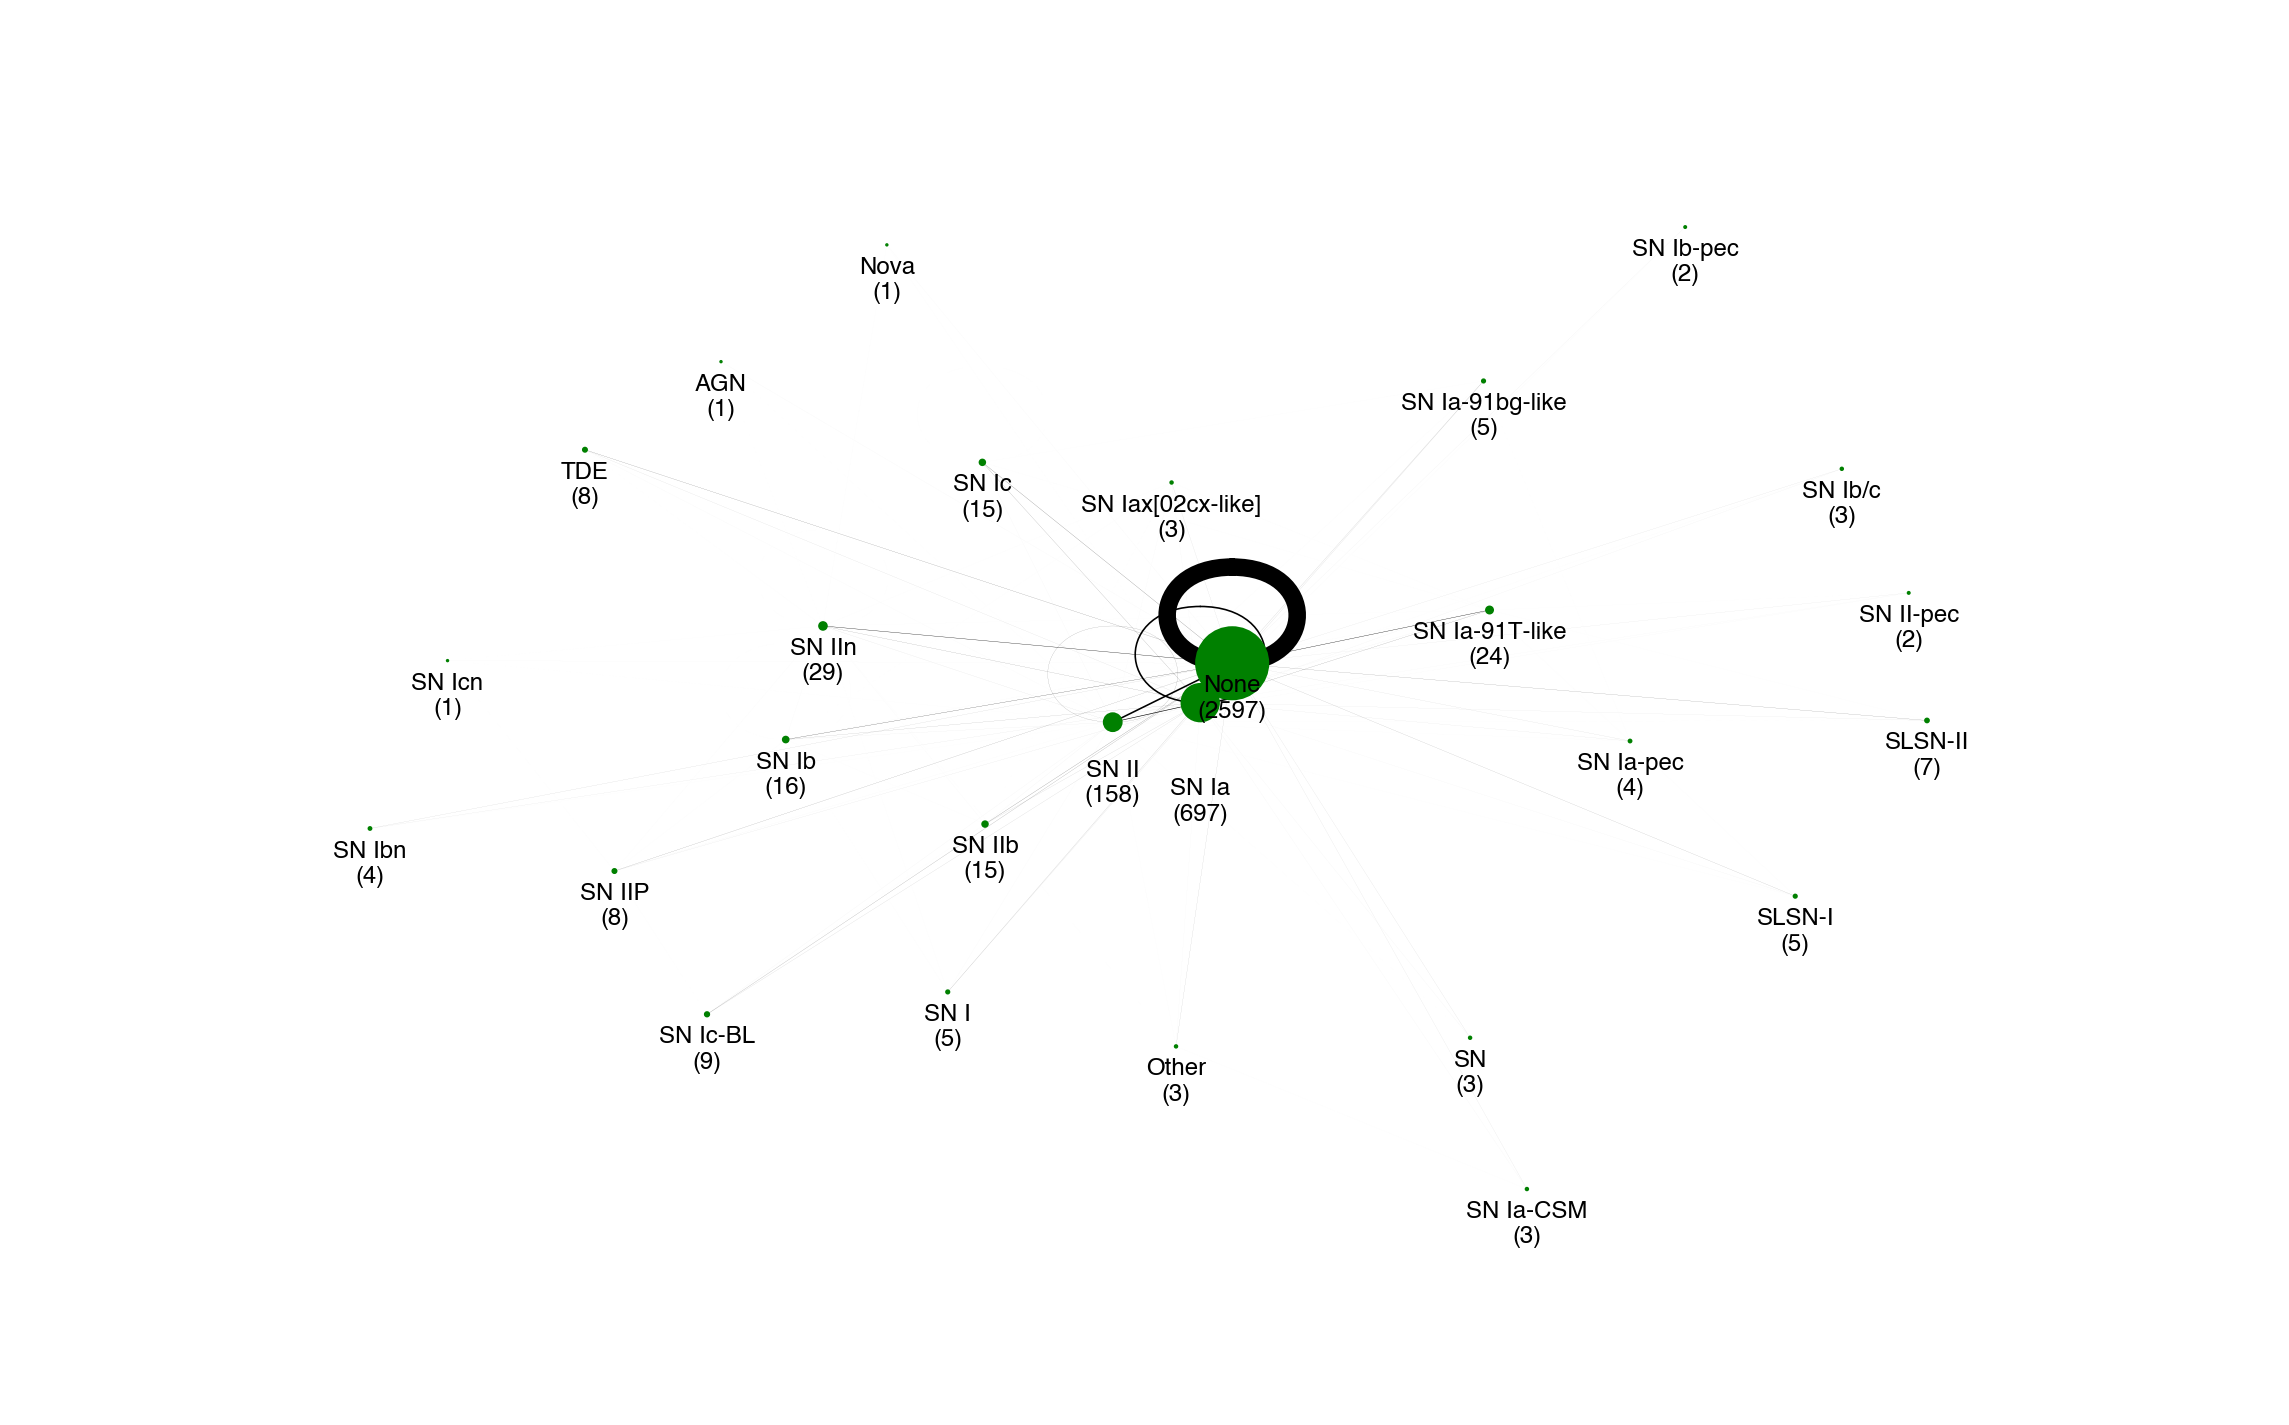

In [50]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


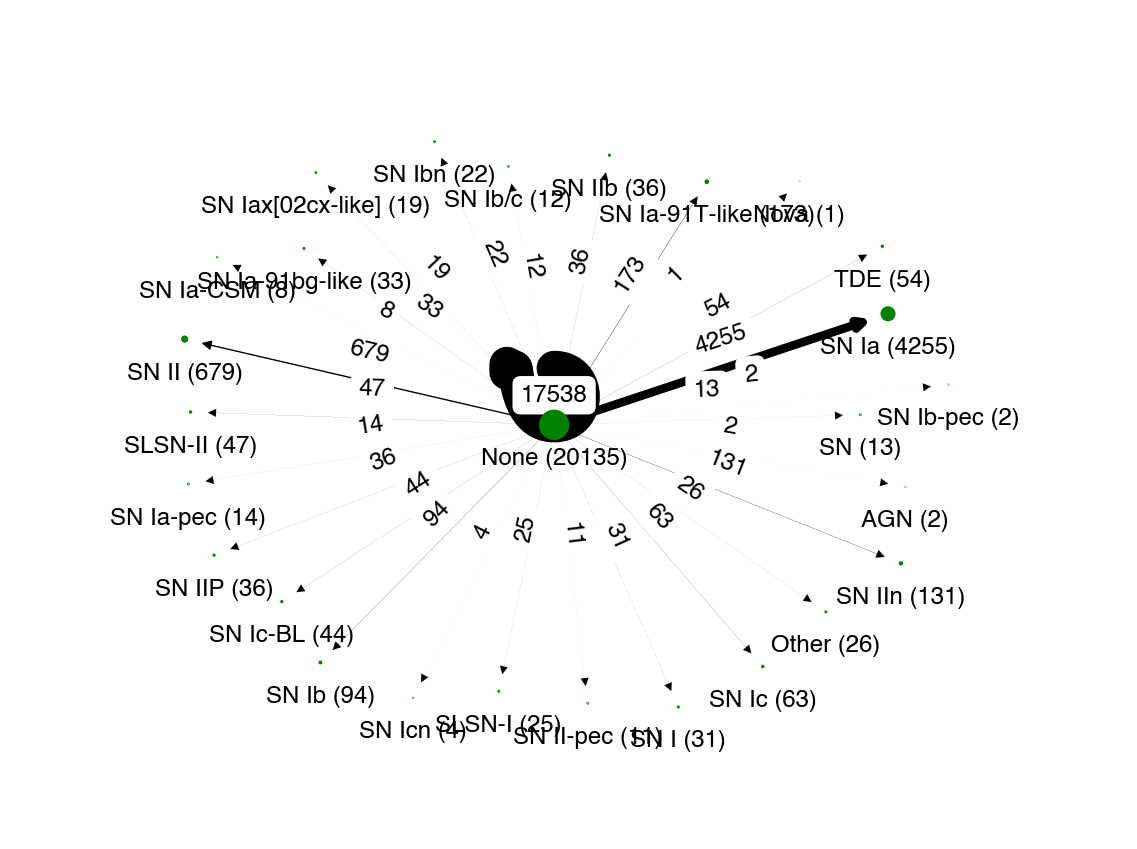

In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


AGN


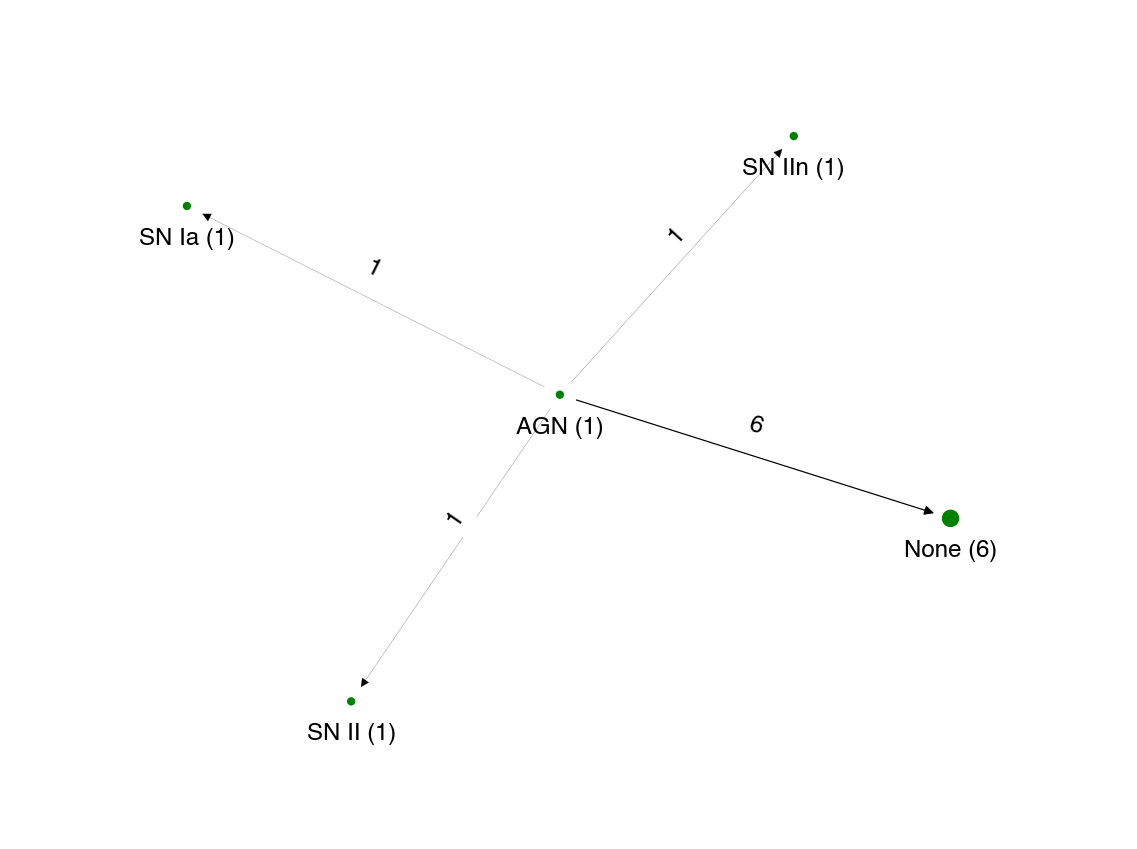

None


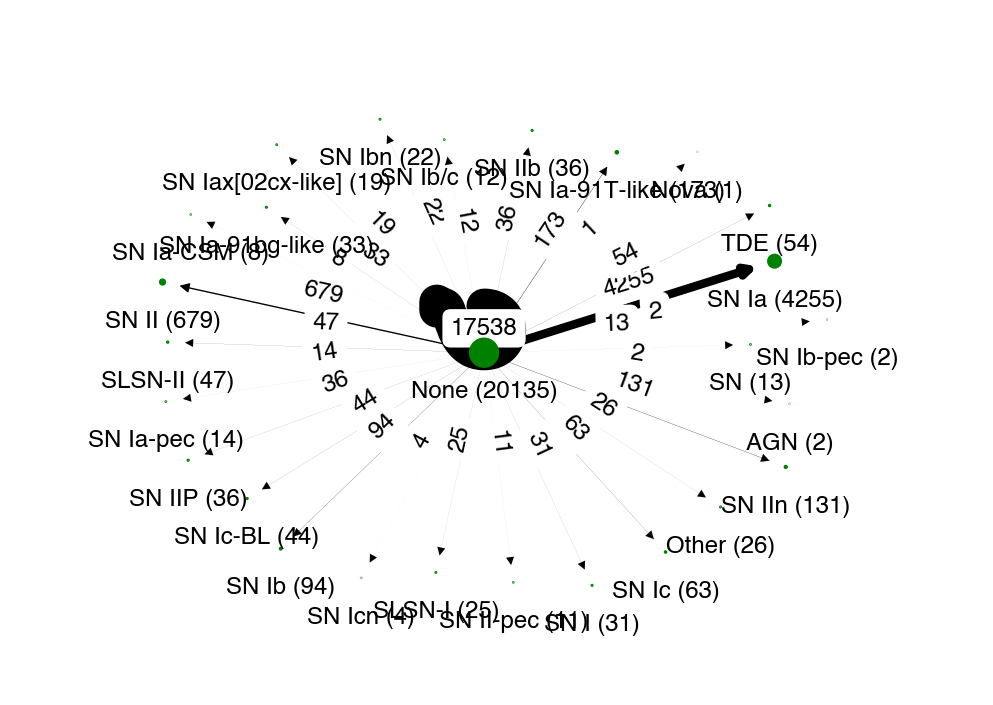

Nova


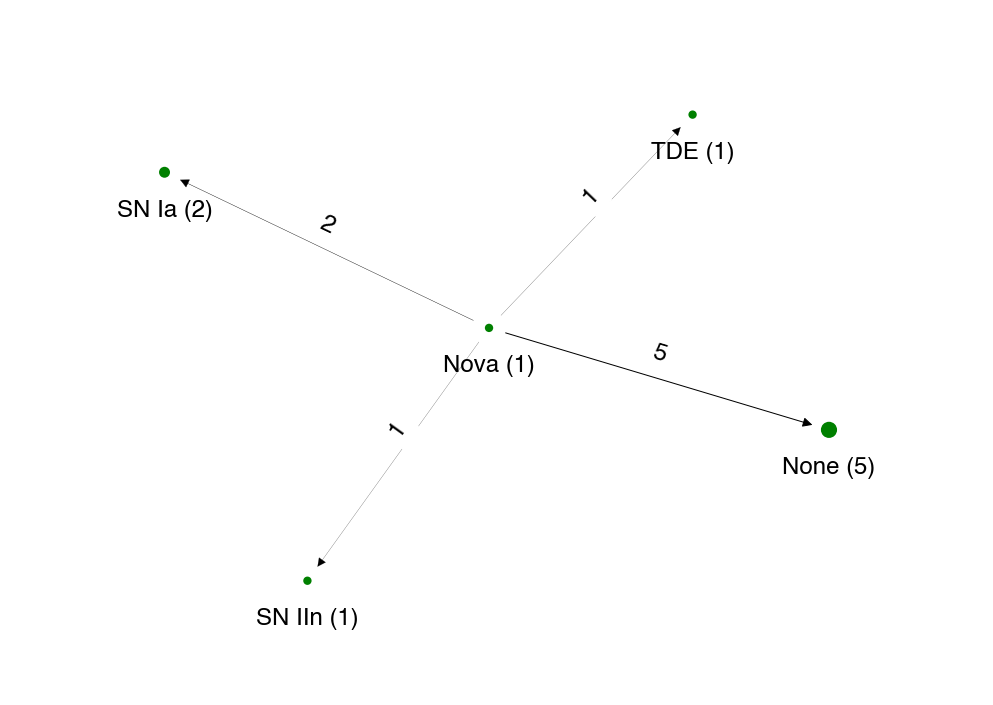

Other


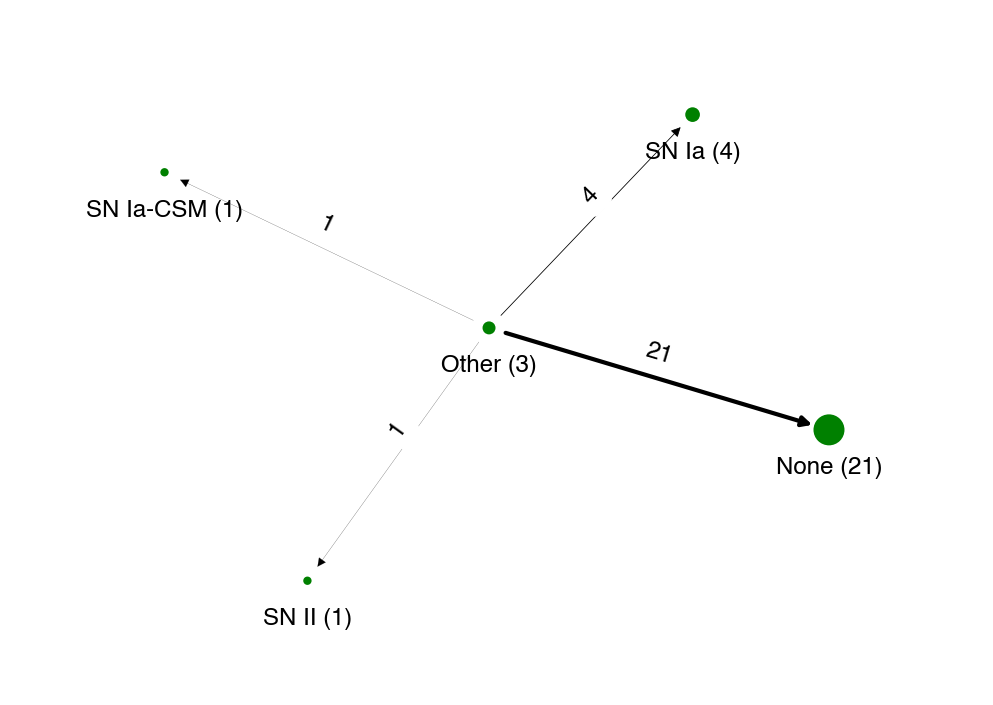

SLSN-I


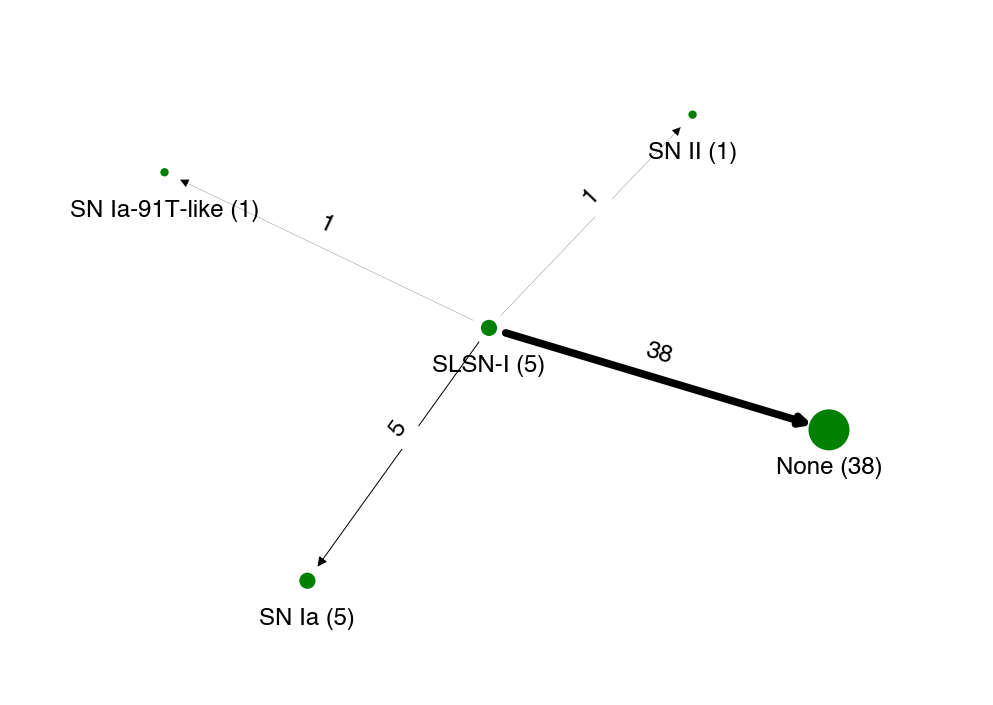

SLSN-II


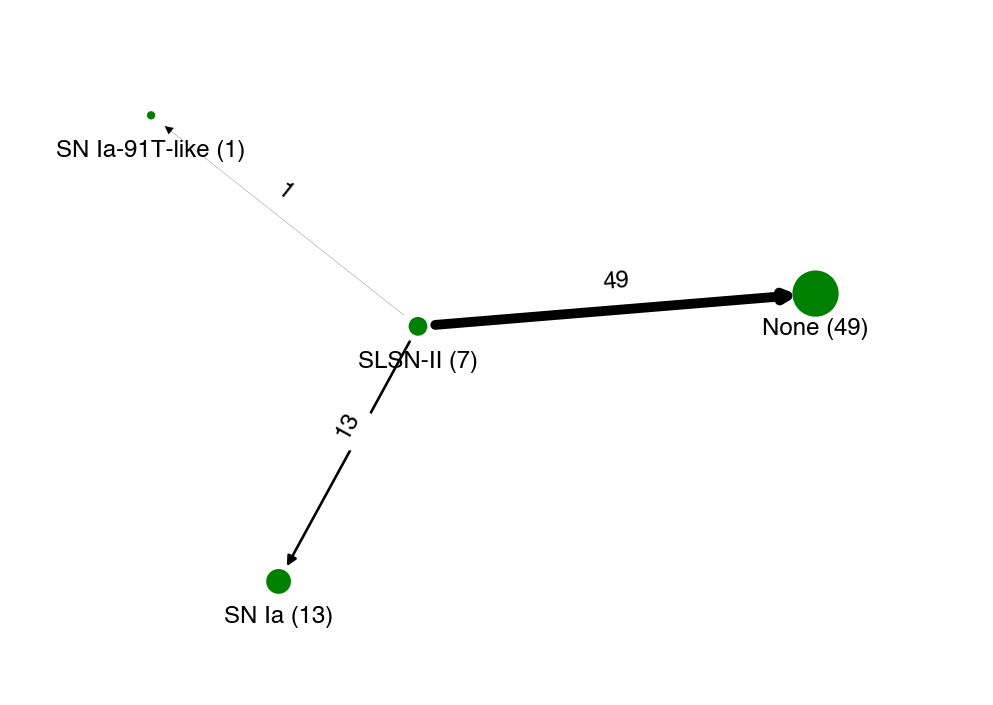

SN


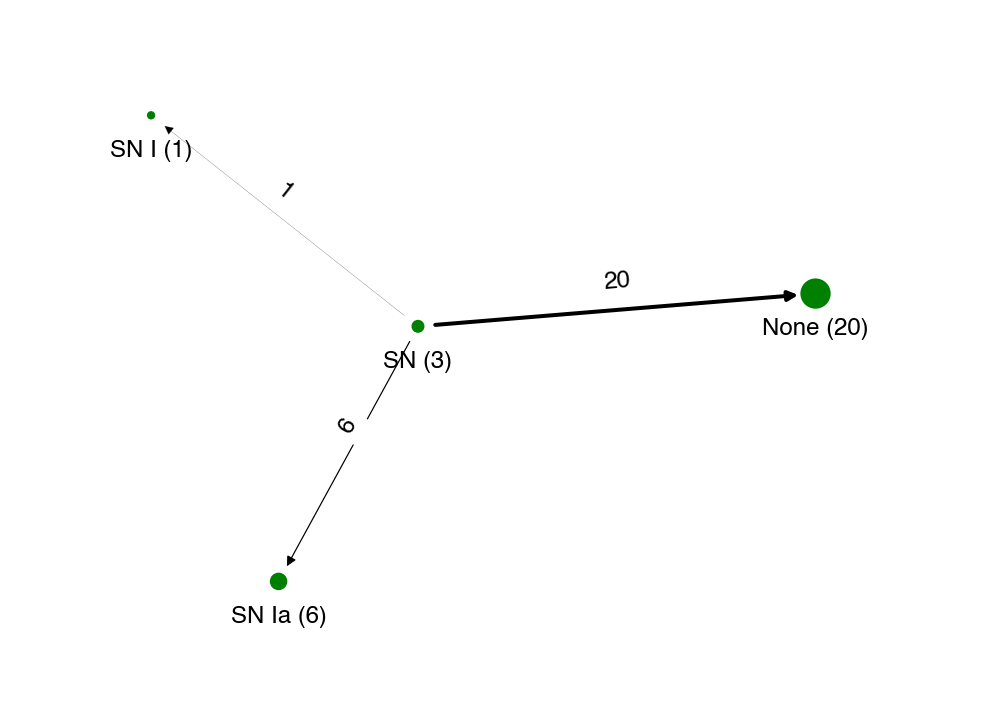

SN I


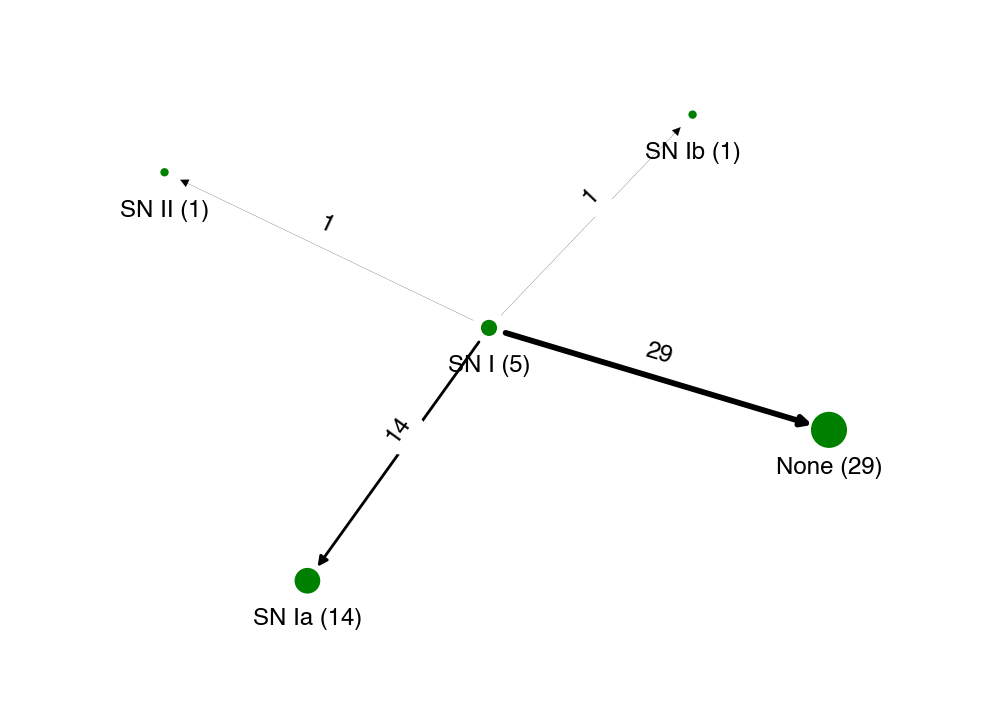

SN II


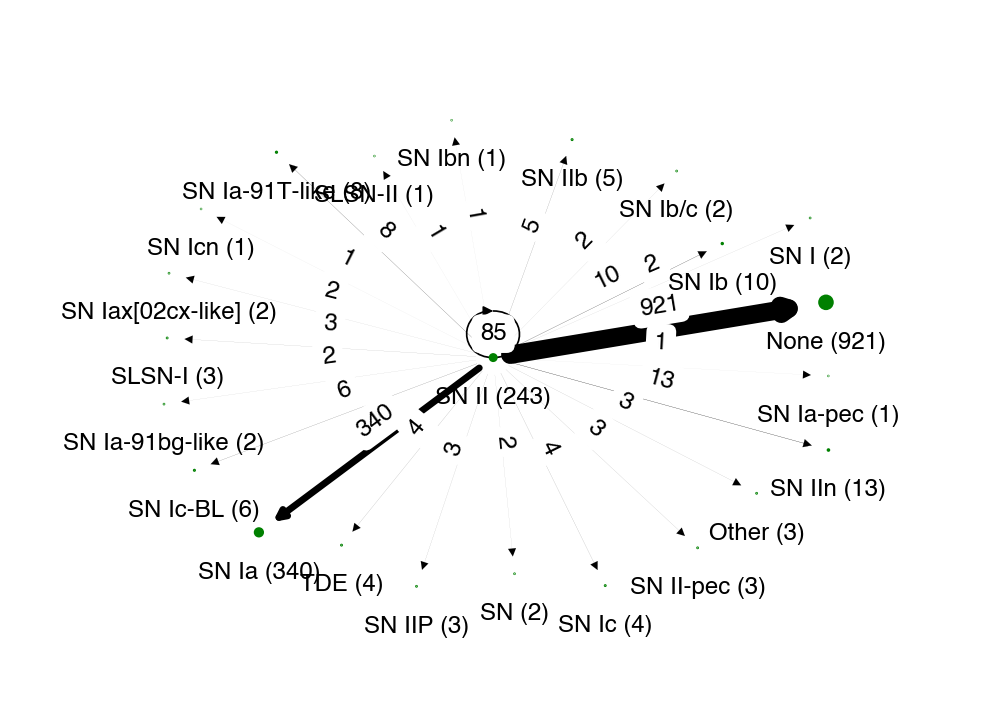

SN II-pec


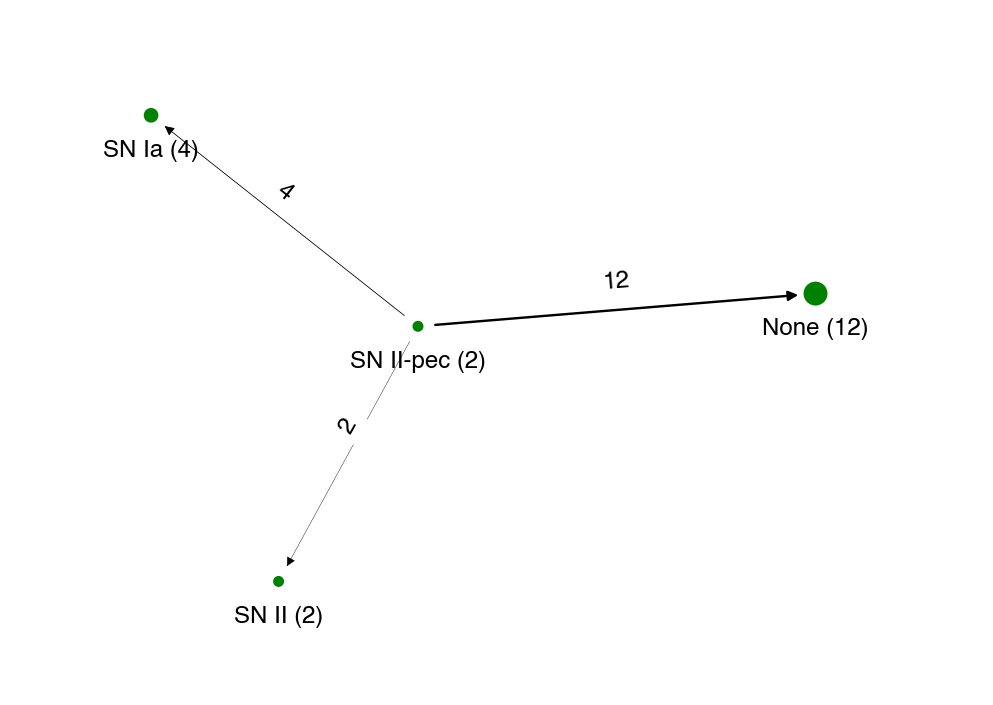

SN IIP


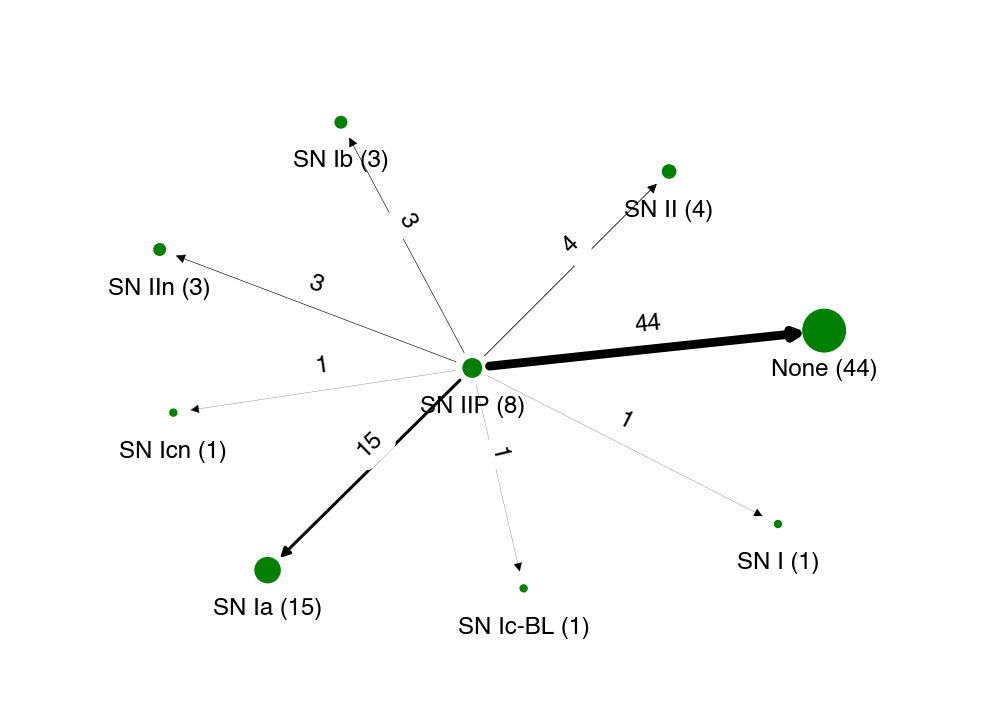

SN IIb


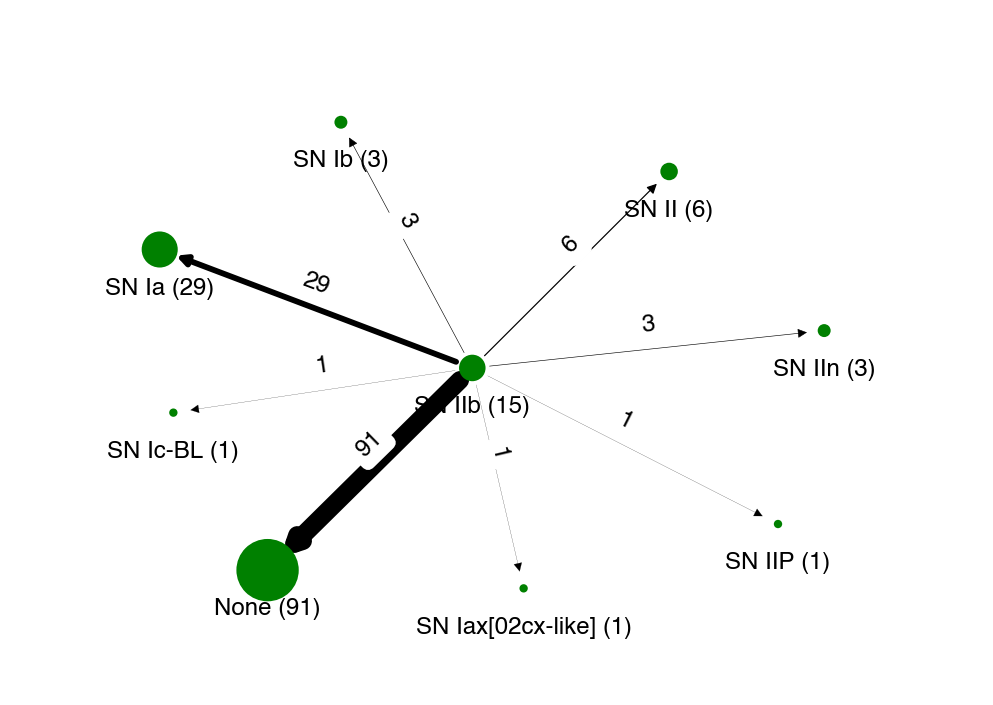

SN IIn


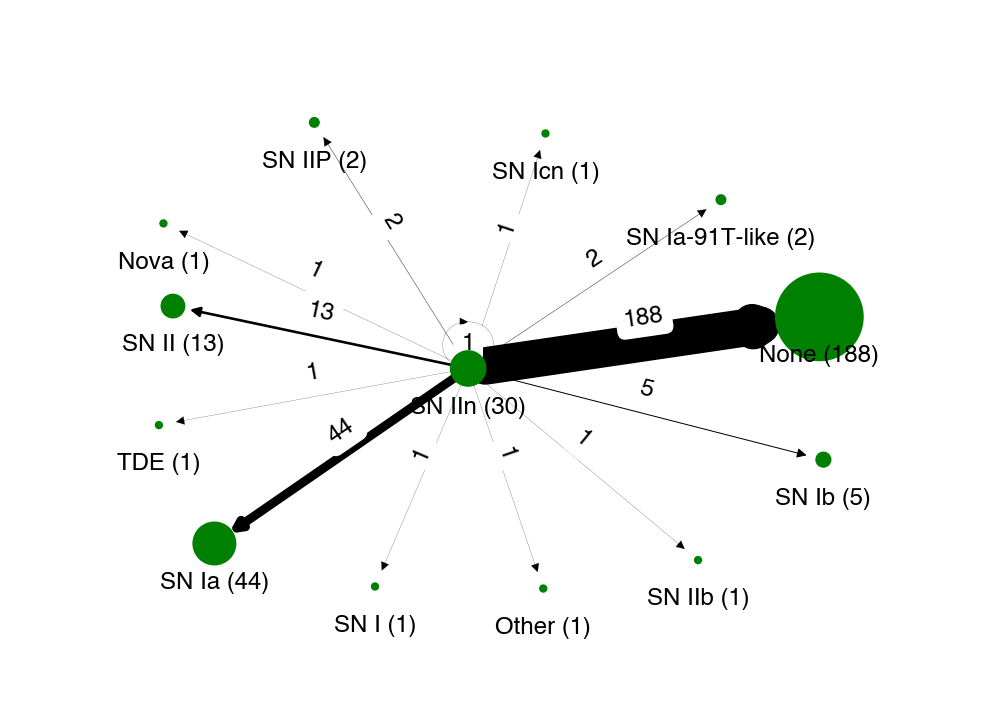

SN Ia


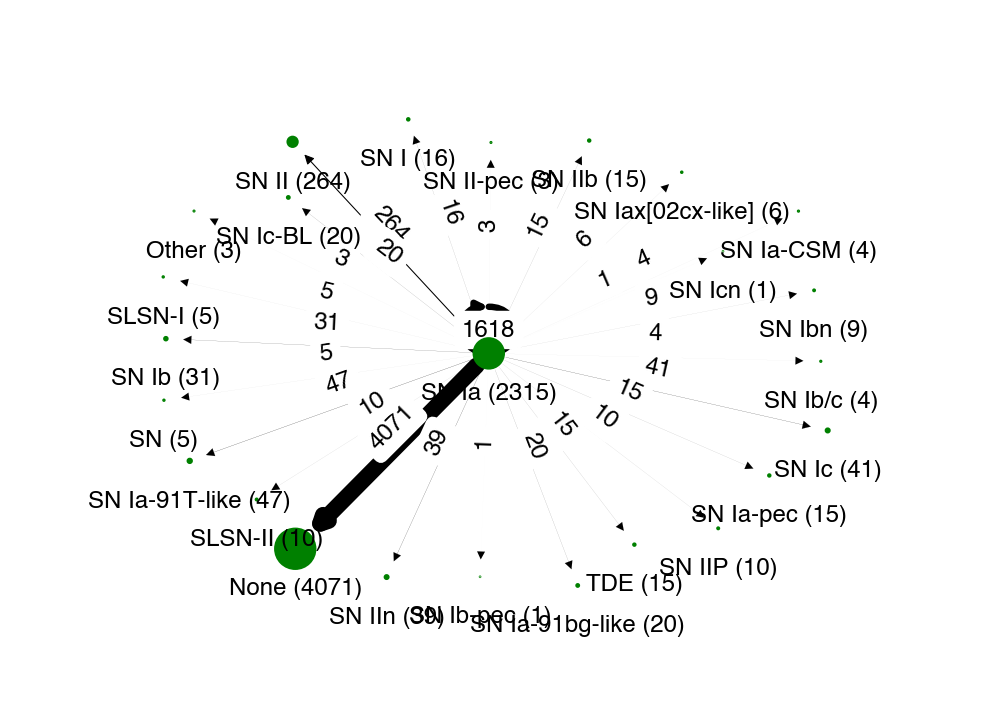

SN Ia-91T-like


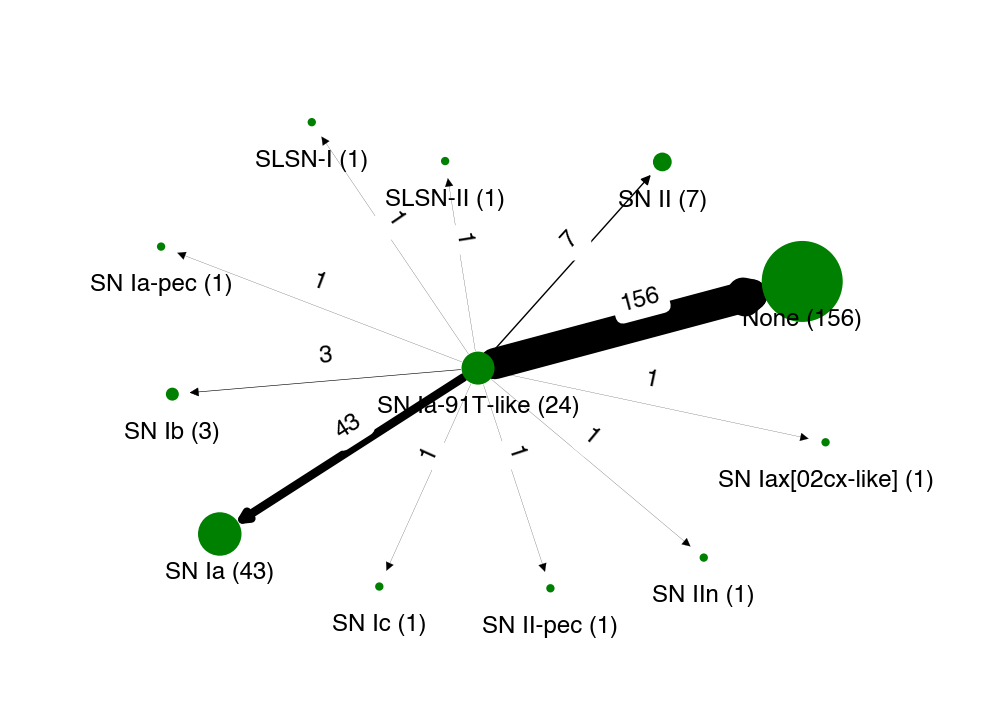

SN Ia-91bg-like


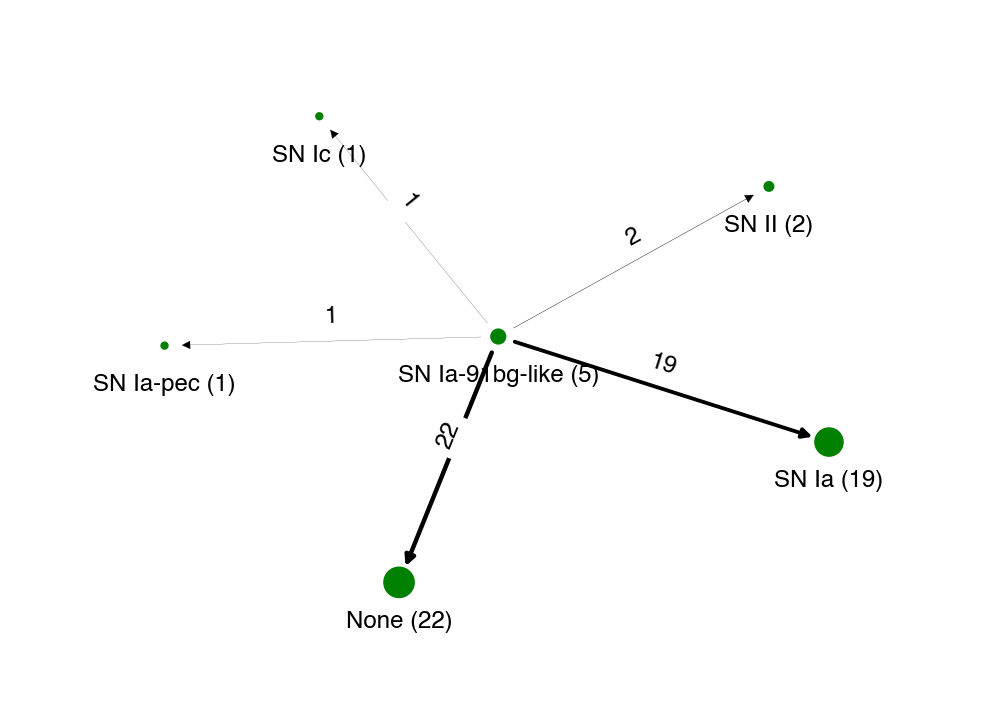

SN Ia-CSM


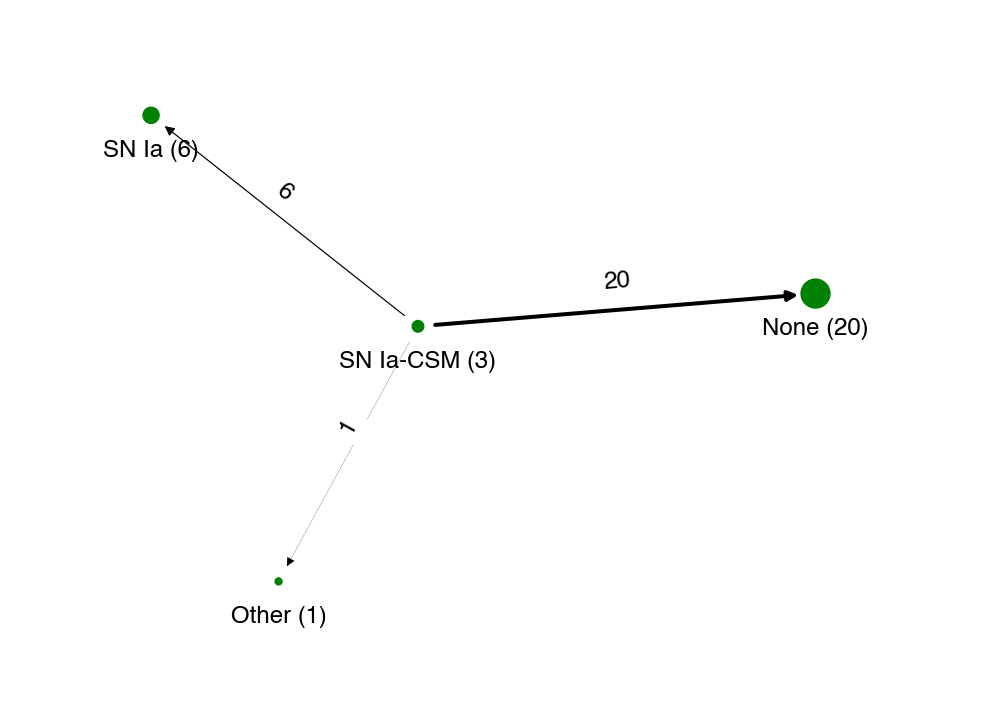

SN Ia-pec


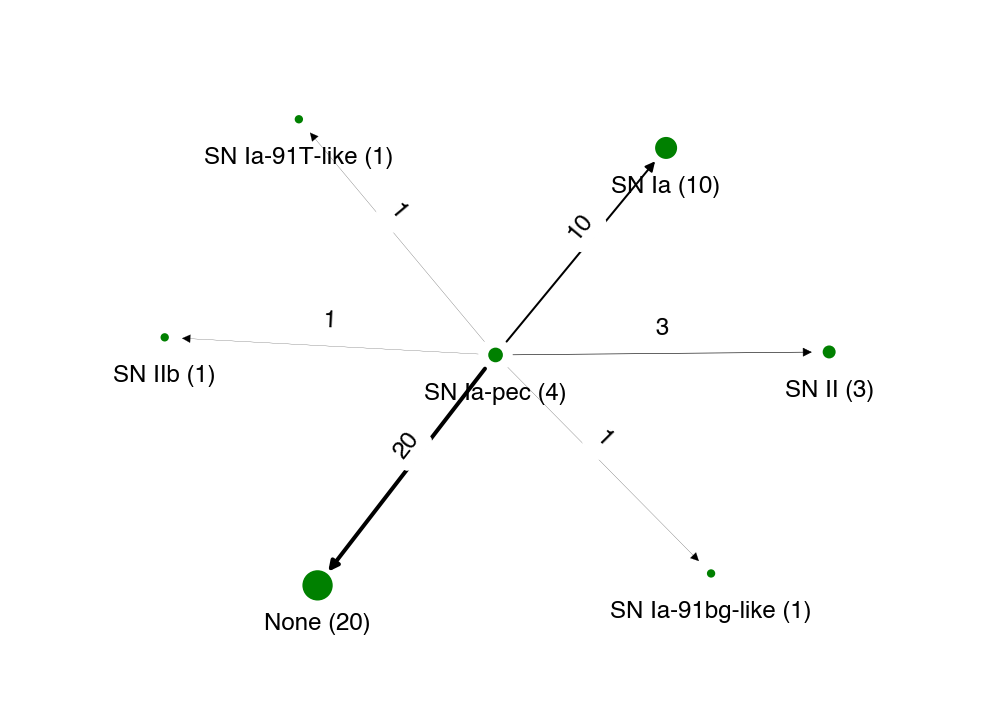

SN Iax[02cx-like]


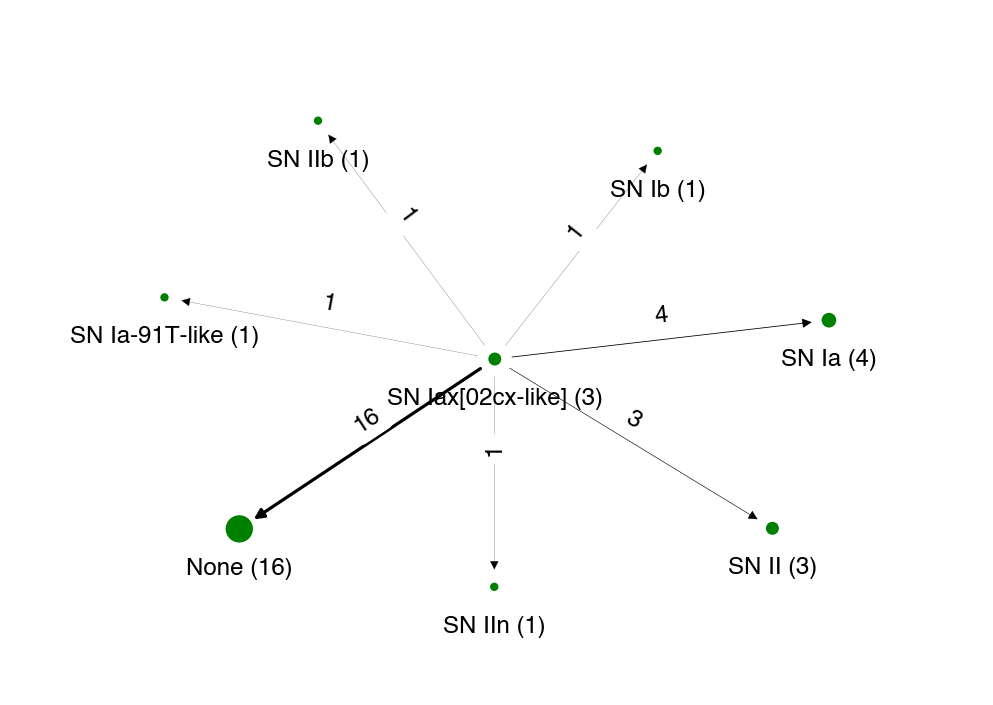

SN Ib


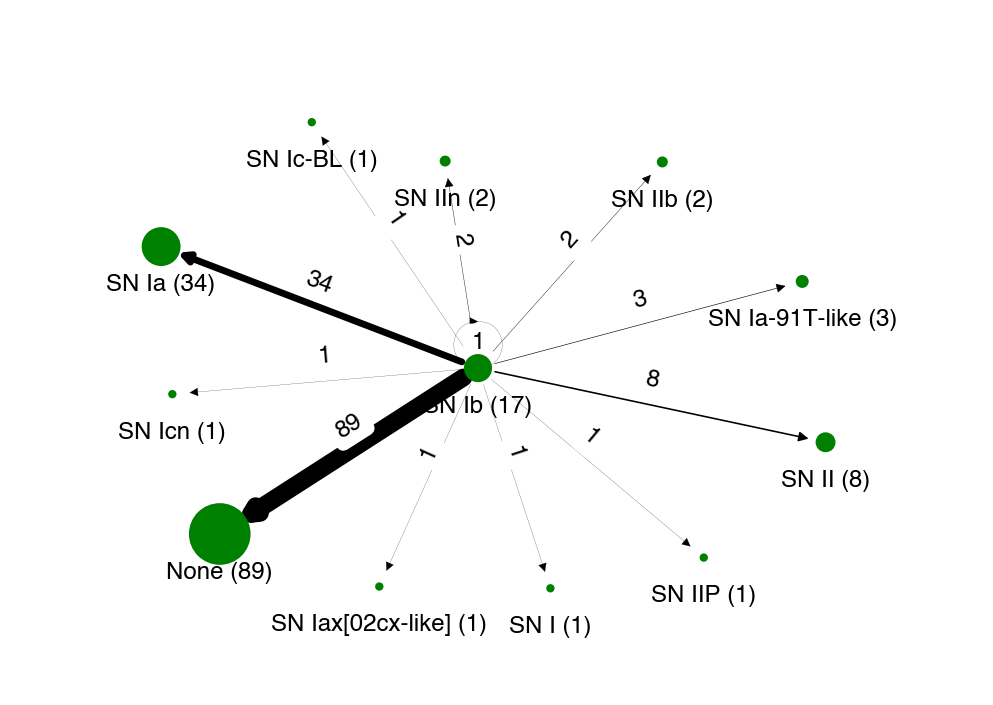

SN Ib-pec


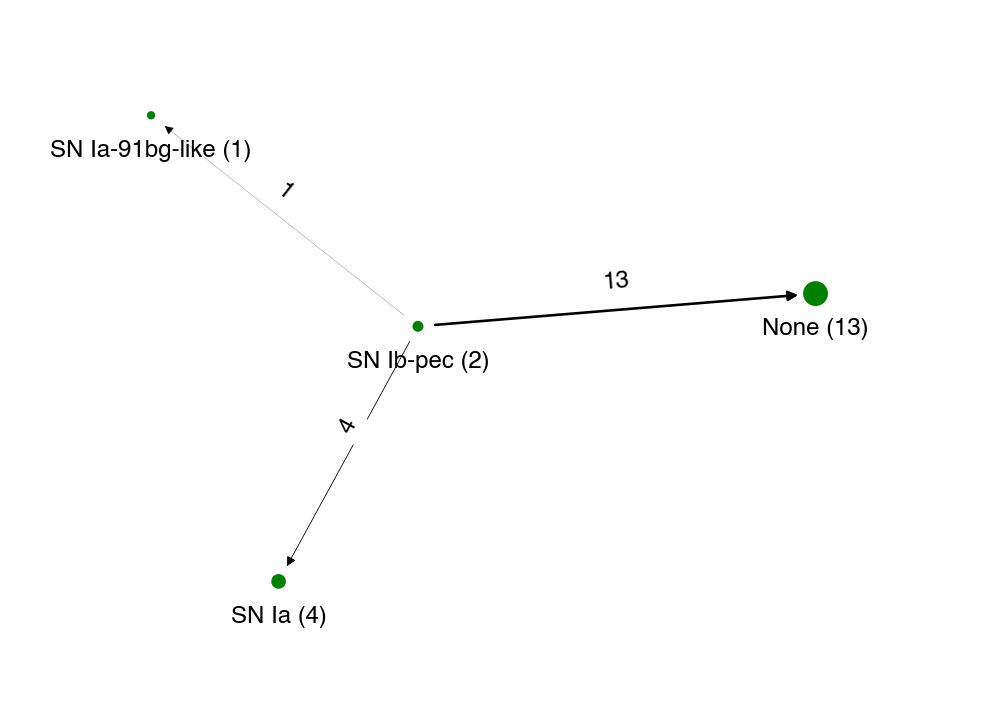

SN Ib/c


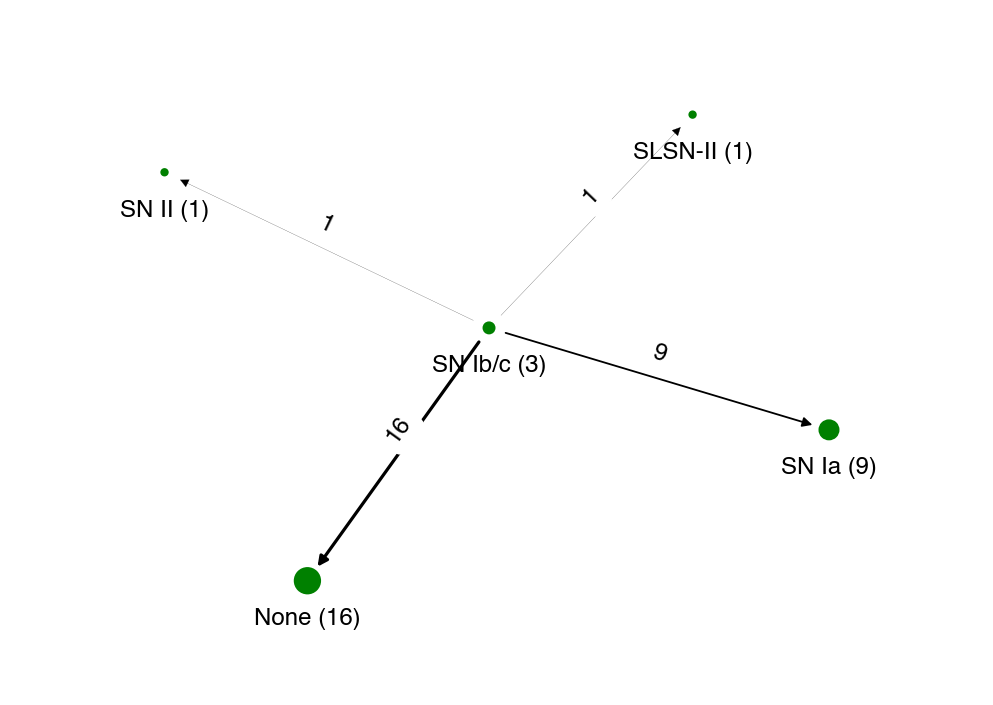

SN Ibn


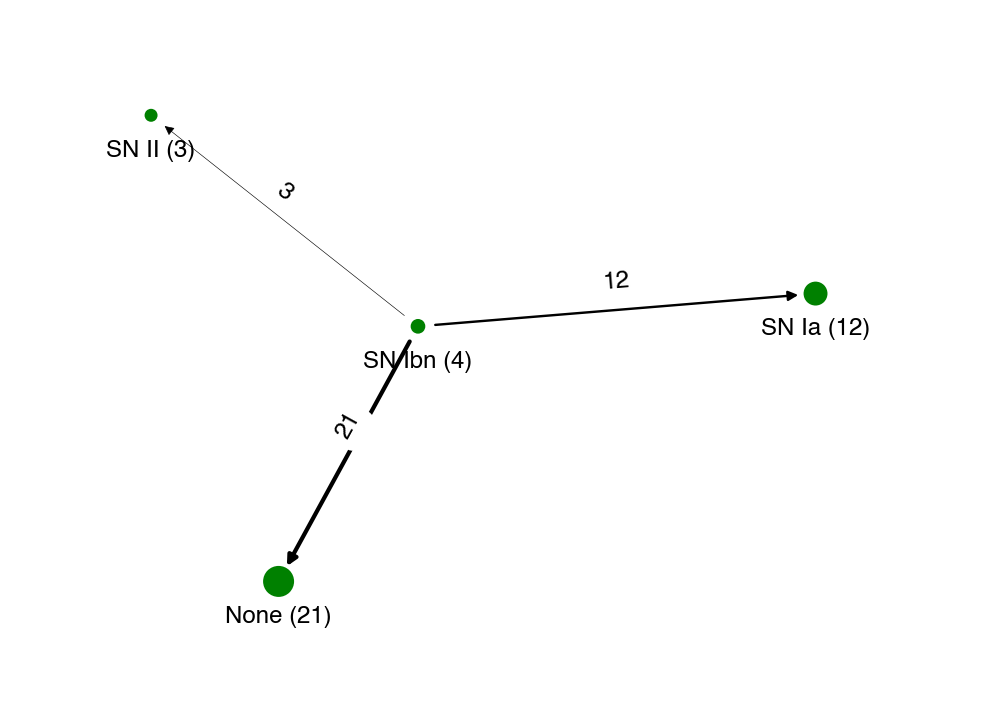

SN Ic


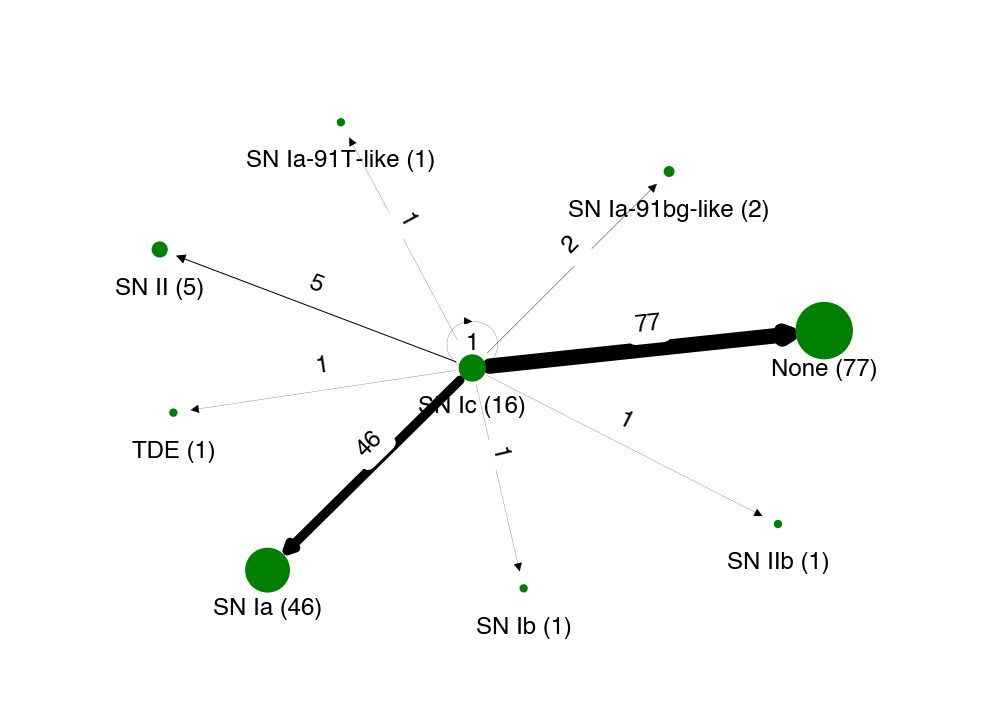

SN Ic-BL


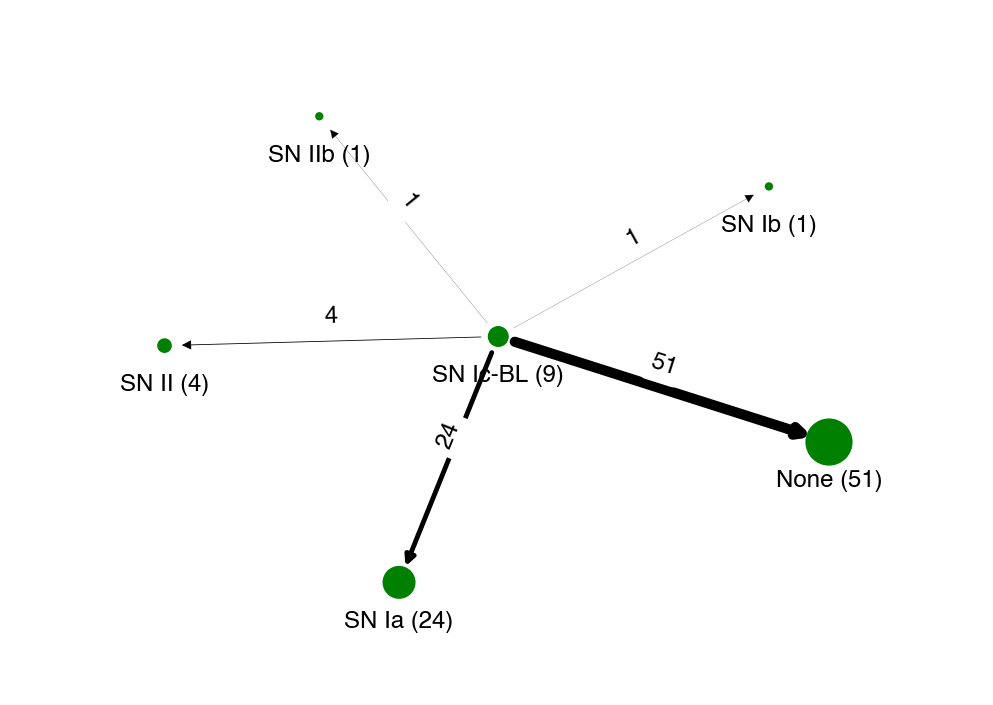

SN Icn


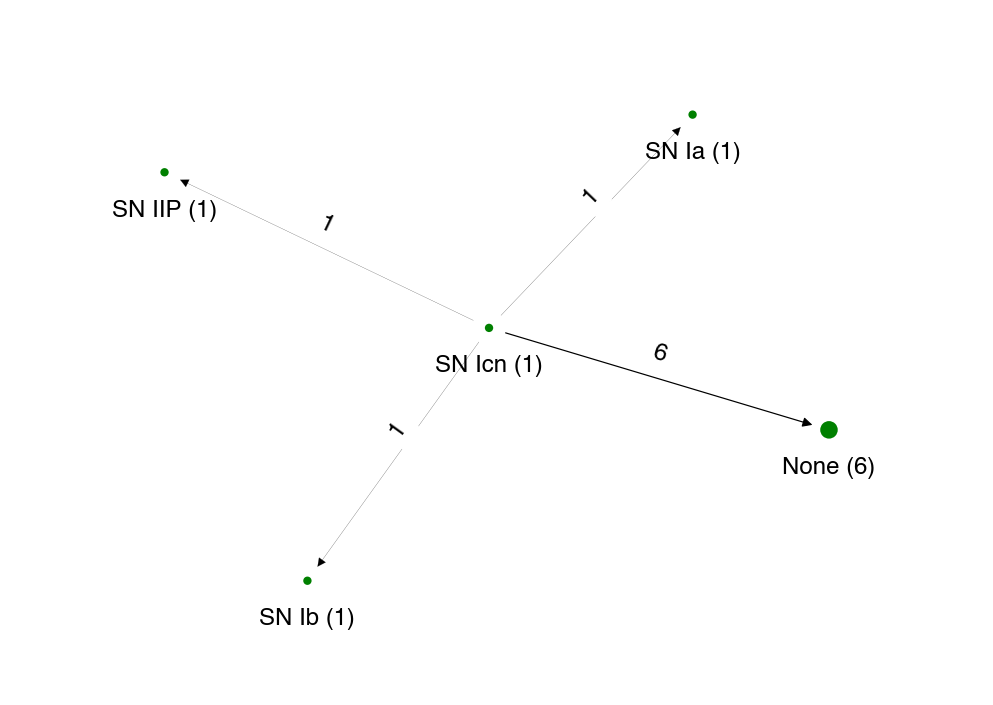

TDE


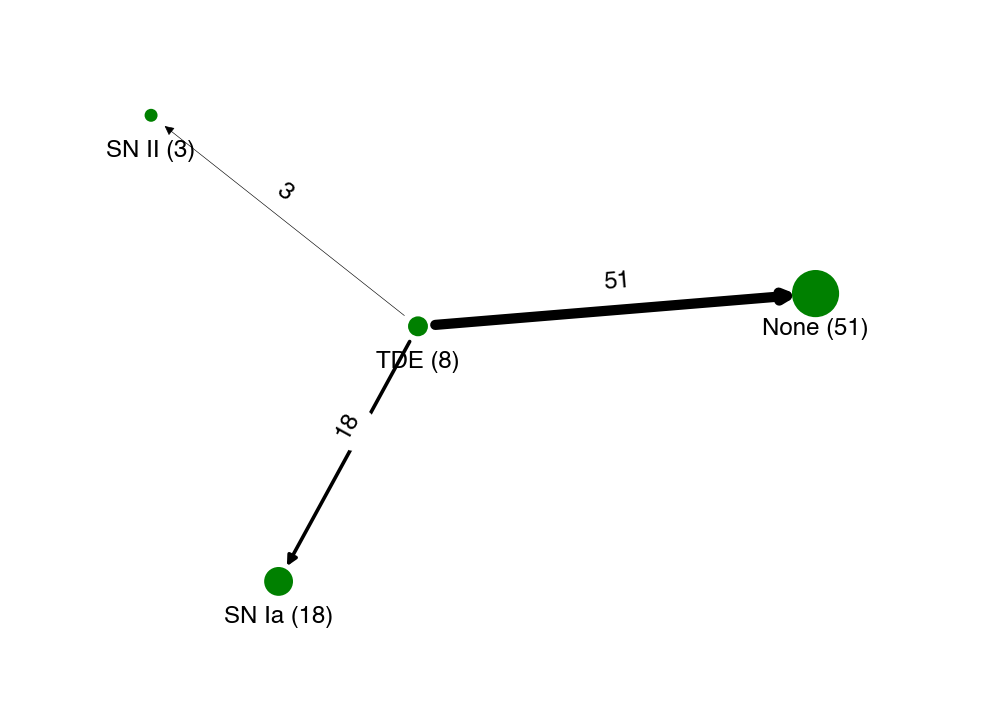

In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
    plt.show()
